# Le but de ce notebook est d'identifier des caractéristiques très simples permettant d'analyser des battements de coeur de foetus

In [8]:
#pip install hyperopt

import os
import pandas as pd
import numpy as np
import copy

# permet de charger les fichiers matlab (*.mat)
from scipy.io import loadmat
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import PercentFormatter
from typing import List,Set,Tuple,Dict

# le répertoire de travail
directory = os.path.abspath('')

# répertoire où se trouvent toutes les données associés à ce challenge
data_directory = os.path.join(directory, 'Data')

# fichier CSV contenant les targets (1 / 0)
targets_path = os.path.join(data_directory, 'CTG_Challenge_files_GroundTruth.csv')

# répertoire où se trouvent les fichiers de données matlab
matlab_directory = os.path.join(data_directory, 'ctg_workshop_database')

# dans l'électrocardiogramme, nous avons 4 mesures par seconde
# chaque mesure correspond au nombre de battements de coeurs par minute
elements_en_1s = 4
elements_en_1minute = int(elements_en_1s*60)
elements_en_5minutes = 5*elements_en_1minute
elements_en_30minutes = 30*elements_en_1minute
elements_en_1heure = 60*elements_en_1minute

# retourne tous les fichiers matlab présents dans le repertoire 'path'
def all_mat_files_in_directory(path: str):
    return [os.path.join(path,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith('.mat')]

# calcule la moyenne de la séquence ''fhr' en ignorant les NaN
def moyenne(fhr):
    return fhr[~np.isnan(fhr)].mean()

# calcule la médiane de la séquence ''fhr' en ignorant les NaN
def mediane(fhr):
    return np.nanmedian(fhr)

# calcule la std dev de la séquence ''fhr' en ignorant les NaN
def ecart_type(fhr):
    return fhr[~np.isnan(fhr)].std()

def proportion_in_interval(fhr, min_value: float, max_value: float) -> float:
    total_points = np.count_nonzero(~np.isnan(fhr))
    if total_points<=0:
        return 0
    total_points_in_interval = np.count_nonzero((fhr > min_value) & (fhr < max_value) )
    return total_points_in_interval/total_points

def points_in_interval_old(fhr, min_value: float, max_value: float) -> int:
    '''
    total_points = np.count_nonzero(~np.isnan(fhr))
    if total_points<=0:
        return 0
    '''
    total_points_in_interval = np.count_nonzero((fhr > min_value) & (fhr < max_value) )
    #return total_points_in_interval/total_points
    return total_points_in_interval


def points_in_interval(fhr, min_value: float, max_value: float) -> int:
    return int(proportion_in_interval(fhr, min_value, max_value)*len(fhr))




# calcul des 3 quartiles Q1 , Q2 (=mediane), Q3 (en ignorant les NaN)
def compute_quartiles_Q1_Q2_Q3(fhr) -> Tuple[float,float,float]:
    # Remove NaN values
    cleaned_data = fhr[~np.isnan(fhr)]
    Q1 = np.percentile(cleaned_data, 25)
    Q2 = np.percentile(cleaned_data, 50)  # This is the median
    Q3 = np.percentile(cleaned_data, 75)
    return Q1,Q2,Q3

def create_dataset_stats(dataset: dict) -> str: 
    count_target_0 = 0
    count_target_1 = 0
    for id in id_to_fhr_last_hour.keys():
        if id_to_target[id] == 0:
            count_target_0 += 1
        else:
            count_target_1 += 1
    count_total = count_target_0+count_target_1
    return f'{(count_total)} elements in dataset: {count_target_0} for target 0 ({round(100*count_target_0/count_total,1)}%) and {count_target_1} for target 1 ({round(100*count_target_1/count_total,1)}%)'

# calcul de l'étendue
def compute_range(fhr) -> float:
    return np.nanmax(fhr)-np.nanmin(fhr)

# nombre d elements NaN dans la séquence 'fhr'
def nan_count(fhr):
    return np.count_nonzero(np.isnan(fhr))



# PRIVE: Chargement des données d'entraînement

In [9]:


# chemin vers tous les fichiers matlab de la base d'entraînement
id_to_path = dict()
for filename in all_mat_files_in_directory(matlab_directory):
    filename_without_extension = os.path.splitext(os.path.basename(filename))[0]    
    id = int(filename_without_extension.lstrip('0'))
    id_to_path[id] = filename

# on charge les targets associés à chaque fichier d'entraînement
targets_df = pd.read_csv(targets_path)
id_to_target = dict()
for _, row in targets_df.iterrows():
    id_to_target[row['ChallengeID']] = row['TrueOutcome']

# lecture des battements de coeurs des foetus
id_to_fhr_full = dict()
id_to_fhr_last_hour = dict() #uniquement la dernière heure
all_lengths = []

for id, path in id_to_path.items():
    matlab_file = loadmat(path)
    # we have 4 (== 'elements_en_1s') points per second, we want 1 point / second
    fhr = matlab_file['fhr'].flatten()
    # Truncate array to make its length a multiple of 4 (== elements_en_1s)
    n_blocks = len(fhr) // elements_en_1s
    truncated = fhr[:n_blocks * elements_en_1s]
    # Reshape into blocks of 4 (== elements_en_1s)
    blocks = truncated.reshape(-1, elements_en_1s)
    # => we average 4 successive points to have 1 value / second
    id_to_fhr_full[id] = np.nanmean(blocks, axis=1)
    id_to_fhr_last_hour[id] = copy.copy(id_to_fhr_full[id][-60*60:])


C:\Users\fzibi\AppData\Local\Temp\ipykernel_23628\2110181609.py:29: RuntimeWarning: Mean of empty slice
  id_to_fhr_full[id] = np.nanmean(blocks, axis=1)


# PRIVE: Calcul de statistiques sur ces données d'entraînement
## (pour faciliter la recherche des caractéristiques)

In [10]:
ids = []
targets = []
mean_last_hour = []
std_dev_last_hour = []
count_last_hour = []
nan_count_last_hour = []
Q1_last_hour = []
Q2_last_hour = []
Q3_last_hour = []
interquartile_range_last_hour = []
etendue_last_hour = []
percent_around_mean_last_hour = []
percent_around_median_last_hour = []
percent_over_80_last_hour = []

for id in list(id_to_fhr_last_hour.keys()):
    ids.append(id)
    targets.append(id_to_target[id])
    fhr_last_hour = id_to_fhr_last_hour[id]
    mean_last_hour.append(moyenne(fhr_last_hour))
    std_dev_last_hour.append(ecart_type(fhr_last_hour)) 
    count_last_hour.append(fhr_last_hour.size)
    nan_count_last_hour.append(nan_count(fhr_last_hour))
    (Q1,Q2,Q3) = compute_quartiles_Q1_Q2_Q3(fhr_last_hour)
    Q1_last_hour.append(Q1)
    Q2_last_hour.append(Q2)
    Q3_last_hour.append(Q3)
    interquartile_range_last_hour.append(Q3-Q1)
    etendue_last_hour.append(compute_range(fhr_last_hour)) 
    mean = moyenne(fhr_last_hour)
    percent_around_mean_last_hour.append(proportion_in_interval(fhr_last_hour, mean-32.8, mean+32.8))
    median = mediane(fhr_last_hour)
    percent_around_median_last_hour.append(proportion_in_interval(fhr_last_hour, median-31.8, median+31.8))
    percent_over_80_last_hour.append(proportion_in_interval(fhr_last_hour, 80, 9999))

    
# Sauvegarde de ces statistiques dans un DataFrame
fhr_stats = pd.DataFrame(
    {'ids': ids,
    'targets': targets,
    'mean_last_hour' : mean_last_hour,
    'std_dev_last_hour' : std_dev_last_hour,
    'count_last_hour' : count_last_hour,
    'nan_count_last_hour' : nan_count_last_hour,
    'Q1_last_hour' : Q1_last_hour,
    'Q2_last_hour' : Q2_last_hour,
    'Q3_last_hour' : Q3_last_hour,
    'interquartile_range_last_hour' : interquartile_range_last_hour,
    'etendue_last_hour' : etendue_last_hour,
    'percent_around_mean_last_hour' : percent_around_mean_last_hour,
    'percent_around_median_last_hour' : percent_around_median_last_hour,
    'percent_over_80_last_hour' :  percent_over_80_last_hour,
    })

# on sauvegarde ces stats sur le disque
fhr_stats.to_csv(os.path.join(directory, 'fhr_stats.csv'), index=False)    

# PRIVE: On supprime les données qui semblent mal labelisées

In [11]:
print(f'Initial dataset before removing any controversials elements:')
print(f'\t{create_dataset_stats(id_to_fhr_last_hour)}')


# pour étendue + std dev
controversials = [27,81,267,274,192,26,153,126,8,161,298,270,67,167,188,210,185,214,172,135,109,196,79,105,297,104,69,21,64,233,90,211,175,248,78,98,180,139,205,217,22,272,12,250,46,283,103,57,150,91,289,164,290,5,291,110,59,295,68,224,232,284,70,87,124,244,17,71,123,241,213,39,49,268,173,234,2,166,56,294,247,170,41,33,243,181,171,235,102,145,108,97,92,34,133,147,251,230,117,249,252,197,203,43,269,25,245,121,281,207,138,242,220,201,20,144,143,101,44,106,263,278,28,200,114,184,76,218,16,276,149,53,14,47,141,125,48,221,193,165,115,52,31,191,199,253,37,186,187,51,288,163,179,38,282,183,219,287,177,174,18,254,42,99,95,258,122,132,209,24,130,169,32,96,131,4,212,231,190,29,93,137,157,120,72,206,62,286,127,277,74,256,225,146,222,86,178,236,19,158,65,259,89,208,168,77,140,257,154,50,7,40,118,58,264,299,54,237,204,36,195,61,94,84,119,266,260,1,85,189,226,45,128,134,142,113,9,83,116,279,35,162,159,112,275,88,55,156,223,100,296,280,80,246,215,271,229,107,160,152,202,111,63,82,30,60,194,273,300,75,176,15,292,265,227,293,262,148,151,136,239,73,182,66,129,238,3,261,23,6,216,13,155,228,255,198,285,10,11,240]

# percentage of controversial elements to discard    
# for instance:
#   0.1 means that the 10% of most controversial elements will be discarded
#   0.0 means that no controverisal elements will be discarded
percentage_controversial_to_discard = 1/6


# to_remove_count[0] : number of elements to remove with target == 0
# to_remove_count[1] : number of elements to remove with target == 1
to_remove_count = [int(percentage_controversial_to_discard*list(id_to_target.values()).count(0)), int(percentage_controversial_to_discard*list(id_to_target.values()).count(1))]

#we discard controversial data (with possible invalid label)
for id in controversials:
    if id in id_to_fhr_last_hour and to_remove_count[id_to_target[id]] > 0 :
        to_remove_count[id_to_target[id]] -= 1
        del id_to_path[id]
        del id_to_target[id]
        del id_to_fhr_full[id]
        del id_to_fhr_last_hour[id]

print(f'Dataset after removing {round(100*percentage_controversial_to_discard,1)}% of most controversials elements:')
print(f'\t{create_dataset_stats(id_to_fhr_last_hour)}')


# percentage of controversial elements to change labels
# for instance:
#   0.1 means that the 10% most controversial elements will have their label changeed
#   0.0 means that we do not change the label
percentage_controversial_to_change_label = 0.0

#we change controversial labels
to_change_label_count = int(percentage_controversial_to_change_label*len(id_to_target)/2)
#we discard controversial data (with possible invalid label)
for id in controversials:
    if id in id_to_fhr_last_hour and to_change_label_count > 0 :
        to_change_label_count -= 1
        id_to_target[id] = 1-id_to_target[id]

        
        
print(f'Dataset after changing labels of {round(100*percentage_controversial_to_change_label,1)}% of most controversials elements:')
print(f'\t{create_dataset_stats(id_to_fhr_last_hour)}')

Initial dataset before removing any controversials elements:
	300 elements in dataset: 240 for target 0 (80.0%) and 60 for target 1 (20.0%)
Dataset after removing 16.7% of most controversials elements:
	250 elements in dataset: 200 for target 0 (80.0%) and 50 for target 1 (20.0%)
Dataset after changing labels of 0.0% of most controversials elements:
	250 elements in dataset: 200 for target 0 (80.0%) and 50 for target 1 (20.0%)


# PRIVE: méthodes permettant l'affichage d'électrocardiogrammes et d'histogrammes

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import copy

def interpolate_nans(array):
    not_nan = ~np.isnan(array)
    indices = np.arange(len(array))
    interpolated_array = np.copy(array)
    interpolated_array[np.isnan(array)] = np.interp(indices[np.isnan(array)], indices[not_nan], array[not_nan])
    return interpolated_array

def display_electrocardiogram(id: int, start_minut:float, duration_in_minuts: float, display_mean: bool = True, interpolate_missing_values:bool = True, min_y_value: int = None, max_y_value: int = None):
    fhr_full = id_to_fhr_full[id]
    start_idx = int(start_minut*60)
    if start_idx<0: 
        start_idx+=len(fhr_full)
    start_idx = max(0, start_idx-1)
    end_idx = min( start_idx+1+int(duration_in_minuts*60) , len(fhr_full) )
    
    fhr = fhr_full[start_idx:end_idx]
    if interpolate_missing_values:
        fhr = interpolate_nans(fhr)
    
    # nombre d'éléments dans l'électrocardiogramme
    n = len(fhr)
    
    # Create an array of time points (assuming each heart rate measurement is taken at regular intervals)
    time_in_minuts = np.arange(n)/(60)
    # Plot the heart rate data
    plt.figure(figsize=(20, 10))
    plt.plot(time_in_minuts, fhr, linestyle='-', color='black', linewidth=1)
    # Formater les ticks pour afficher le temps au format hh:mm
    def format_func(time_in_minuts, tick_number):
        #time_in_minuts = int(time_in_minuts/(60))
        hours = int(time_in_minuts) // 60
        minutes = int(time_in_minuts) % 60
        return f'{hours:02d}:{minutes:02d}'
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    comment = 'sujet sain' if id_to_target[id] == 0 else 'sujet malade'
    
    if display_mean:
        observed_mean = int(moyenne(fhr))
        plt.axhline(y=observed_mean, color='red', linewidth=1, linestyle='-', label='Moyenne: '+str(observed_mean))
        # Annotate the y-value on the vertical axis
        plt.text(x=0, y=observed_mean, s=f'{observed_mean:.0f}', color='red', va='center', ha='right')

    # Add labels and title
    plt.xlabel('Temps (minutes)', fontsize=15)
    plt.ylabel('Battements de coeur par minutes', fontsize=15)
    plt.title(f"Electrocardiogramme pour un {comment} ({id})", fontsize=15)
    plt.xlim(0, max(time_in_minuts))
    plt.ylim(min_y_value or 60, max_y_value or 180)
    # Display grid
    plt.grid(True)

    if display_mean:
        plt.legend()
    # Show the plot
    plt.show()


def display_histogram(id: int, start_minut:float, duration_in_minuts: float, display_mean: bool = True):
    fhr_full = id_to_fhr_full[id]
    start_idx = int(start_minut*60)
    if start_idx<0: 
        start_idx+=len(fhr_full)
    start_idx = max(0, start_idx-1)
    end_idx = min( start_idx+1+int(duration_in_minuts*60) , len(fhr_full) )
    data = fhr_full[start_idx:end_idx]
    # we discard NaN
    data = data[~np.isnan(data)] 
    plt.figure(figsize=(16, 6))  # Increase the width for better horizontal display
    # Plotting the histogram
    counts, bins, patches = plt.hist(data, bins=30, edgecolor='black', weights=[100/len(data)]*len(data))
    
    # Adding title and labels
    comment = 'sujet sain' if id_to_target[id] == 0 else 'sujet malade'

    plt.title("Histogramme")
    plt.xlabel('Nombre de battements de coeur à la minute')
    plt.ylabel('Fréquence (%)')

    if display_mean:
        observed_mean = int(moyenne(data))
        plt.axvline(observed_mean, color='red', linestyle='-', linewidth=2)
        plt.text(observed_mean, plt.ylim()[1]*0.9, f'Moyenne: {observed_mean:.2f}', color='red', ha='center')
    
    # Display the plot
    plt.show()


def display_electrocardiograms(count:int, start_minut:int, duration_in_minuts: int, label: int, start_id:int = 1, display_mean: bool = True, interpolate_missing_values:bool = True, min_y_value: int = None, max_y_value: int = None):
    displayed_count = 0
    for idx in range(start_id, start_id+300,1):
        id = idx if idx <=300 else idx-300
        if id not in id_to_target:
            continue
        if id_to_target[id] != label:
            continue
        display_electrocardiogram(id, start_minut, duration_in_minuts, display_mean=display_mean, interpolate_missing_values=interpolate_missing_values, min_y_value=min_y_value, max_y_value=max_y_value)
        display_histogram(id, start_minut, duration_in_minuts, display_mean=display_mean)
        displayed_count+= 1
        if displayed_count>=count:
            break

# Affichage d'exemples de données pour des sujets sains

In [ ]:
nombre_a_afficher = 10
start_minut = -60
duration_in_minuts = 30
label = 0  #0 pour les sujets sains , 1 pour les sujets malades
start_id =1 # id du 1er élément à afficher

display_electrocardiograms(nombre_a_afficher, start_minut, duration_in_minuts, label, start_id, display_mean=True, interpolate_missing_values=True)

# Affichage d'exemples de données pour des sujets malades

In [ ]:
nombre_a_afficher = 10
start_minut = -60
duration_in_minuts = 30
label = 1  #0 pour les sujets sains , 1 pour les sujets malades
start_id = 1 # id du 1er élément à afficher


display_electrocardiograms(nombre_a_afficher, start_minut, duration_in_minuts, label, start_id, display_mean=True, interpolate_missing_values=True)

# PRIVE: Liste des caractéristiques

In [15]:
import functools

@functools.lru_cache(maxsize=None)
def proportion_in_interval_last_hour(id: int, min_value: float, max_value: float) -> float:
    return proportion_in_interval(id_to_fhr_last_hour[id], min_value, max_value)

@functools.lru_cache(maxsize=None)
def points_in_interval_last_hour(id: int, min_value: float, max_value: float) -> int:
    return points_in_interval(id_to_fhr_last_hour[id], min_value, max_value)

# calcul de l'écart type
@functools.lru_cache(maxsize=None)
def compute_id_std_dev_last_hour(id: int):
    return ecart_type(id_to_fhr_last_hour[id])

# caracteristique 1: sujet sain si l'écart-type est inférieur à un seuil.
def calcul_caracteristique1(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if compute_id_std_dev_last_hour(id) < hyperparameters['seuil_'+suffix] else 1

# calcul de l'écart interquartile (en ignorant les NaN)
@functools.lru_cache(maxsize=None)
def compute_id_interquartile_range_last_hour(id: int) -> float:
    (Q1,Q2,Q3) = compute_quartiles_Q1_Q2_Q3(id_to_fhr_last_hour[id])
    return Q3-Q1

# caracteristique 2: sujet sain si l'écart interquartile est inférieur à un seuil
def calcul_caracteristique2(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if compute_id_interquartile_range_last_hour(id) < hyperparameters['seuil_'+suffix] else 1

# calcul de l'etendue de la séquence associée à l'id 'id' en ignorant les NaN
@functools.lru_cache(maxsize=None)
def compute_id_range_last_hour(id: int):
    return compute_range(id_to_fhr_last_hour[id])

# caracteristique 3: sujet sain si l'étendue est inférieure à un seuil.
def calcul_caracteristique3(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if compute_id_range_last_hour(id)< hyperparameters['seuil_'+suffix] else 1


# calcul de la moyenne de la séquence associée à l'id 'id' en ignorant les NaN
@functools.lru_cache(maxsize=None)
def compute_id_mean_last_hour(id: int):
    return moyenne(id_to_fhr_last_hour[id])



# caracteristique 4: sujet sain si le pourcentage de points autour de la moyenne est supérieur à un seuil.
def calcul_caracteristique4(id: int, hyperparameters: dict, suffix: str) -> int:
    range4 = hyperparameters['range_'+suffix]
    moyenne = compute_id_mean_last_hour(id)
    return 0 if proportion_in_interval_last_hour(id, moyenne-range4, moyenne+range4) > hyperparameters['seuil_'+suffix] else 1



# caracteristique 5: sujet sain si le pourcentage de points autour de la médiane est supérieur à un seuil.
def calcul_caracteristique5(id: int, hyperparameters: dict, suffix: str) -> int:
    range_5 = hyperparameters['range_'+suffix]
    median = compute_id_mean_last_hour(id)
    return 0 if proportion_in_interval_last_hour(id, median-range_5, median+range_5) > hyperparameters['seuil_'+suffix] else 1



# caracteristique 6: sujet sain si le pourcentage de points dans un intervalle [min_range_6, +infini] est supérieur à un seuil
def calcul_caracteristique6(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if proportion_in_interval_last_hour(id, hyperparameters['min_range_'+suffix], 999) > hyperparameters['seuil_'+suffix] else 1


# caracteristique 6A: sujet sain si le nombre de points dans un intervalle [min_range_6A, +infini] est supérieur à un seuil
def calcul_caracteristique6A(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if points_in_interval_last_hour(id, hyperparameters['min_range_'+suffix], 999) > hyperparameters['seuil_'+suffix] else 1



# caracteristique 6C: sujet sain si le pourcentage de points dans un intervalle [mean - range_6C, +infini] est supérieur à un seuil
def calcul_caracteristique6C(id: int, hyperparameters: dict, suffix: str) -> int:
    mean = compute_id_mean_last_hour(id)
    return 0 if proportion_in_interval_last_hour(id, mean-hyperparameters['range_'+suffix], 999) > hyperparameters['seuil_'+suffix] else 1
        


# caracteristique 7: sujet sain si le pourcentage de points dans un intervalle [min_range_7, min_range_7+range_7] est supérieur à un seuil
def calcul_caracteristique7(id: int, hyperparameters: dict, suffix: str) -> int:
    min_range = hyperparameters['min_range_'+suffix]
    max_range = min_range+hyperparameters['range_'+suffix]
    return 0 if proportion_in_interval_last_hour(id, min_range, max_range) > hyperparameters['seuil_'+suffix] else 1

# caracteristique 7A: sujet sain si le nombre de points dans un intervalle [min_range_7A, min_range_7A+range_7A] est supérieur à un seuil
def calcul_caracteristique7A(id: int, hyperparameters: dict, suffix: str) -> int:
    min_range = hyperparameters['min_range_'+suffix]
    max_range = min_range+hyperparameters['range_'+suffix]
    return 0 if points_in_interval_last_hour(id, min_range, max_range) > hyperparameters['seuil_'+suffix] else 1

# caracteristique 7C: sujet sain si le pourcentage de points dans un intervalle [mean-min_range_7C, mean+max_range_7C] centré autour de la moyenne est supérieur à un seuil
def calcul_caracteristique7C(id: int, hyperparameters: dict, suffix: str) -> int:
    min_range_7C = hyperparameters['min_range_'+suffix]
    max_range_7C = hyperparameters['max_range_'+suffix]
    mean = compute_id_mean_last_hour(id)
    return 0 if proportion_in_interval_last_hour(id, mean-min_range_7C, mean+max_range_7C) > hyperparameters['seuil_'+suffix] else 1

# caracteristique 7D: sujet sain si le pourcentage de points dans un intervalle [mean-range_7D, mean+range_7D] centré autour de la moyenne est supérieur à un seuil
def calcul_caracteristique7D(id: int, hyperparameters: dict, suffix: str) -> int:
    range_7D = hyperparameters['range_'+suffix]
    mean = compute_id_mean_last_hour(id)
    return 0 if proportion_in_interval_last_hour(id, mean-range_7D, mean+range_7D) > hyperparameters['seuil_'+suffix] else 1



# caracteristique 8: sujet sain si le pourcentage de points dans un intervalle [0, max_range_8] est supérier à un seuil
def calcul_caracteristique8(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if proportion_in_interval_last_hour(id, 0, hyperparameters['max_range_'+suffix]) > hyperparameters['seuil_'+suffix] else 1

# caracteristique 8A: sujet sain si le nombre de points dans un intervalle [0, max_range_8A] est supérieur à un seuil
def calcul_caracteristique8A(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if points_in_interval_last_hour(id, 0, hyperparameters['max_range_'+suffix]) > hyperparameters['seuil_'+suffix] else 1

# caracteristique 8C: sujet sain si le pourcentage de points dans un intervalle [0, mean + range_8C] est supérieur à un seuil
def calcul_caracteristique8C(id: int, hyperparameters: dict, suffix: str) -> int:
    mean = compute_id_mean_last_hour(id)
    return 0 if proportion_in_interval_last_hour(id, 0, mean+hyperparameters['range_'+suffix]) > hyperparameters['seuil_'+suffix] else 1



# calcul de la médiane de la séquence associée à l'id 'id' en ignorant les NaN
@functools.lru_cache(maxsize=None)
def compute_id_median_last_hour(id: int):
    return mediane(id_to_fhr_last_hour[id])



# PRIVE: Hyperparameters Management

In [16]:
import numpy as np
from sklearn.metrics import f1_score
import math
from hyperopt import fmin, tpe, space_eval, hp, Trials, rand as hyperopt_rand
import hashlib
import random
import time
import sys

current_lowest_error = None
stats_hpo = dict()
last_time_display_stats_hpo = time.time()

def compute_error(TP: int, TN: int, FP: int, FN: int):
    return 1.0-(TP+TN)/(TP+TN+FP+FN)
    # to compute error as : (error(target0)+error(target1)/2 , uncomment following line:
    #return (compute_error_target0(TP,TN,FP,FN)+compute_error_target1(TP,TN,FP,FN))/2
    
    
def compute_f1_score(TP: int, TN: int, FP: int, FN: int):
    return (2*TP)/(2*TP+FP+FN)
        
def compute_error_target0(TP: int, TN: int, FP: int, FN: int):
    return 1.0-TN/(1*TN+FP)

def compute_error_target1(TP: int, TN: int, FP: int, FN: int):
    return 1.0-TP/(1*TP+FN)
        
def compute_matrice_de_confusion(id_to_predictions, id_to_target) -> (int, int, int,int):
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for id, data in id_to_predictions.items():
            target = id_to_target[id]
            prediction = id_to_predictions[id]
            if prediction == target: # bonne prediction
                if target == 1:
                    TP += 1
                else:
                    TN += 1
            else: # erreur dans la prediciton
                if prediction == 1:
                    FP += 1
                else:
                    FN += 1
        return (TP,TN,FP,FN)

def compute_single_prediction_single_caracteristique(id: str, hyperparameters: dict, caracteristique: str) -> int:  
    return globals()['calcul_caracteristique'+caracteristique](id, hyperparameters, caracteristique)

def compute_single_prediction(id: str, hyperparameters: dict) -> int:  
    valeurs_caracteristiques_a_utiliser = []
    for c in hyperparameters['caracteristiques_a_utiliser'].split('+'):
        valeurs_caracteristiques_a_utiliser.append(compute_single_prediction_single_caracteristique(id, hyperparameters, c))
    if not all_elements_same(valeurs_caracteristiques_a_utiliser):
        return hyperparameters['label_si_resultats_differents']
    return valeurs_caracteristiques_a_utiliser[0]
    
def all_elements_same(data):
    first_element = data[0]
    return all(element == first_element for element in data)

def compute_all_predictions(hyperparameters: dict) -> dict:
    id_to_predictions = dict()
    for id in id_to_fhr_last_hour.keys():
        id_to_predictions[id] = compute_single_prediction(id, hyperparameters)
    return id_to_predictions
    
def train(hyperparameters: dict, verbose: bool) -> dict:
    id_to_predictions = compute_all_predictions(hyperparameters)
    (TP,TN,FP,FN) = compute_matrice_de_confusion(id_to_predictions, id_to_target)
    metrics = dict()
    metrics['TP'] = TP
    metrics['TN'] = TN
    metrics['FP'] = FP
    metrics['FN'] = FN
    metrics['error_target0'] = compute_error_target0(TP,TN,FP,FN)
    metrics['error_target1'] = compute_error_target1(TP,TN,FP,FN)
    current_error = compute_error(TP,TN,FP,FN)
    metrics['erreur'] = current_error
    global last_time_display_stats_hpo
    if (time.time()-last_time_display_stats_hpo)>600:
        last_time_display_stats_hpo = time.time()
    global current_lowest_error
    if not current_lowest_error or current_error<current_lowest_error:
        current_lowest_error = current_error
        if verbose:
            print(f"new lowest error {round(current_error,4)} for hyperparameters {[c for c in hyperparameters.items() if c[1] is not None]}")
    return metrics
    
# the objective used for Hyperparameters Optimization (HPO)
# it is the function to minimize
def objective(sample_from_search_space):
    hyperparameters = fix_hyperparameters(sample_from_search_space)
    model_name = get_model_name(hyperparameters)
    if model_name in already_processed_model_names_with_hpo:
        metrics = already_processed_model_names_with_hpo[model_name]
    else:
        metrics = train(hyperparameters, True)
        already_processed_model_names_with_hpo[model_name] = metrics
    # we want to minimize this mettric ('erreur')
    return metrics['erreur']

hpo_session_id = str(int(100*time.time()))

def extract_caracteristique_id(key: str):
    if key == 'caracteristiques_a_utiliser' or key == 'label_si_resultats_differents':
        return None
    splitted = key.split('_')
    if len(splitted)>=2 and len(splitted[-1]) >=1 and splitted[-1][0].isdigit():
        return splitted[-1]
    return None

# When conducting an HPO search, some hyperparameters may exhibit inconsistent values.
# This method aims to address those inconsistencies.
def fix_hyperparameters(hyperparameters: dict) -> dict :
    res = dict(hyperparameters)
    for key in list(res.keys()):
        caracteristique_id = extract_caracteristique_id(key)
        if caracteristique_id and caracteristique_id not in res['caracteristiques_a_utiliser'].split('+'):
            del res[key]
    if '+' not in res['caracteristiques_a_utiliser']:
        res['label_si_resultats_differents'] = None
    return res

# Transform the dictionary of hyperparameters 'hyperparameters' into string.
def hyperparameters_to_str(hyperparameters: dict) -> str:
    sorted_hyperparameters = sorted (hyperparameters.items())
    return "\n".join([hyperparameter_name+" = "+str(hyperparameter_value) for (hyperparameter_name,hyperparameter_value) in sorted_hyperparameters if hyperparameter_value is not None])

def get_model_name(hyperparameters: dict) -> str:
    file_content = hyperparameters_to_str(hyperparameters)
    return compute_hash(file_content, 10)

def compute_hash(input_string, max_length):
    # Calculate MD5 hash of the input string
    md5_hash = hashlib.md5(input_string.encode('ascii')).hexdigest().upper()
    # Return the hash truncated to the max_length
    return md5_hash[:max_length]

def launch_hpo(max_evals: int):
    seed = random.randint(0, 100000)
    print(f'using seed: {seed}')
    rstate = np.random.default_rng(seed)
    best_indexes = fmin(
        fn=objective,  # "Loss" function to minimize
        space=search_space,  # Hyperparameter space
        algo=hyperopt_rand.suggest, #Random Search
        #algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
        max_evals=max_evals,  # Perform 'max_evals' trials
        max_queue_len = 10,
        rstate =rstate,
    )

    # Get the best parameters
    best  = space_eval(search_space, best_indexes)
    print(f"Found minimum after {max_evals} trials:")
    print([c for c in best.items() if c[1] is not None])
    return best



def float_range(x1: float, x2: float, count:int = 100) -> List[float]:
    epsilon = (x2-x1)/count
    # Generate the range of float values with the specified step
    return list(np.arange(x1, x2, epsilon))

def int_range(x:int, y:int, count:int = 100) -> List[int]:
    epsilon = int ((y+1-x)/count )
    epsilon = max(epsilon, 1)
    return list(range(x, y+1,epsilon))




search_space = {
    
    # caracteristique 1: sujet sain si l'écart type est inférieur à un seuil.
    'seuil_1': hp.choice('seuil_1', float_range(15.0, 30.0, 1000)),

    # caracteristique 2: sujet sain si l'écart interquartile est inférieur à un seuil
    'seuil_2': hp.choice('seuil_2', float_range(15, 40.0, 1000)),

    # caracteristique 3: sujet sain si l'étendue est inférieure à un seuil.
    'seuil_3': hp.choice('seuil_3', int_range(120,250)),

    # caracteristique 4: sujet sain si le pourcentage de points autour de la moyenne est supérieur à un seuil.
    'range_4': hp.choice('range_4', int_range(10,50)),
    'seuil_4': hp.choice('seuil_4', float_range(0.80, 0.99,100)),

    # caracteristique 5: sujet sain si le pourcentage de points autour de la médiane est supérieur à un seuil.
    'range_5': hp.choice('range_5', float_range(30,35)),
    'seuil_5': hp.choice('seuil_5', float_range(0.80, 0.90)),

    
    # caracteristique 6: sujet sain si le pourcentage de points dans un intervalle [min_range_6, +infini] est supérieur à un seuil
    'min_range_6': hp.choice('min_range_6', int_range(50,100)),
    'seuil_6': hp.choice('seuil_6', float_range(0.8, 1.0)),

    # caracteristique 6A: sujet sain si le nombre de points dans un intervalle [min_range_6A, +infini] est supérieur à un seuil
    'min_range_6A': hp.choice('min_range_6A', int_range(50, 100)),
    'seuil_6A': hp.choice('seuil_6A', int_range(int(0.8*14400), 14400)),

    # caracteristique 6C: sujet sain si le pourcentage de points dans un intervalle [mean - range_6C, +infini] est supérieur à un seuil
    'range_6C': hp.choice('range_6C', int_range(0, 50)),
    'seuil_6C': hp.choice('seuil_6C', float_range(0.8, 1.0)),
    
    
    
    # caracteristique 7: sujet sain si le pourcentage de points dans un intervalle [min_range_7, min_range_7+range_7] est supérieur à un seuil
    'min_range_7': hp.choice('min_range_7', int_range(50,150)),
    'range_7': hp.choice('range_7', int_range(100, 180)),
    'seuil_7': hp.choice('seuil_7', float_range(0.80, 1.0)),

    # caracteristique 7A: sujet sain si le nombre de points dans un intervalle [min_range, max_range] est supérieur à un seuil
    'min_range_7A': hp.choice('min_range_7A', int_range(50,100)),
    'range_7A': hp.choice('range_7A', int_range(100, 180)),
    'seuil_7A': hp.choice('seuil_7A', int_range(int(0.8*14400), 14400)),
    

    # caracteristique 7C: sujet sain si le pourcentage de points dans un intervalle [mean-min_range_7C, mean+max_range_7C] centré autour de la moyenne est supérieur à un seuil
    'min_range_7C': hp.choice('min_range_7C', int_range(0,50)),
    'max_range_7C': hp.choice('max_range_7C', int_range(0, 50)),
    'seuil_7C': hp.choice('seuil_7C', float_range(0.80, 1.0)),

    
    # caracteristique 7D: sujet sain si le pourcentage de points dans un intervalle [mean-range_7D, mean+range_7D] centré autour de la moyenne est supérieur à un seuil
    'range_7D': hp.choice('range_7D', int_range(0,100)),
    'seuil_7D': hp.choice('seuil_7D', float_range(0.70, 1.0)),
    
    
    
    # caracteristique 8: sujet sain si le pourcentage de points dans un intervalle [0, max_range_8] est supérier à un seuil
    'max_range_8': hp.choice('max_range_8', int_range(100,200)),
    'seuil_8': hp.choice('seuil_8', float_range(0.8, 1.0)),

    
    # caracteristique 8A: sujet sain si le nombre de points dans un intervalle [0, max_range_8A] est supérieur à un seuil
    'max_range_8A': hp.choice('max_range_8A', int_range(130,230)),
    'seuil_8A': hp.choice('seuil_8A', int_range(int(0.8*14400), 14400)),
    
    # caracteristique 8C: sujet sain si le pourcentage de points dans un intervalle [0, mean + range_8C] est supérieur à un seuil
    'range_8C': hp.choice('range_8C', int_range(20,200)),
    'seuil_8C': hp.choice('seuil_8C', float_range(0.8, 1.0)),

    #pour faire une recherche sur 2 caractéristiques en même temps, par exemple 3 et 6C
    #'caracteristiques_a_utiliser': hp.choice('caracteristiques_a_utiliser', ['3+6C']),
    
    #pour faire une recherche sur 1 seule caractéristique, par exemple 7A
    #'caracteristiques_a_utiliser': hp.choice('caracteristiques_a_utiliser', ['7A']),

    
    'caracteristiques_a_utiliser': hp.choice('caracteristiques_a_utiliser', ['7A']),
    
    'label_si_resultats_differents': hp.choice('label_si_resultats_differents', [0, 1]),
}



max_evals = 500
print(f'max_evals value is {max_evals}')

already_processed_model_names_with_hpo = dict()
start_time = time.time()
# Uncomment following line to enable HPO
#best = launch_hpo(max_evals)
print(f'hpo took {round(time.time()-start_time,2)}s')



max_evals value is 500
hpo took 0.0s


<hr style="height:2px; border-width:0; color:black; background-color:black">
<span style="font-size: 48px;">1ère partie</span>
<hr style="height:2px; border-width:0; color:black; background-color:black">

## Faire constater par l'étudiant que l'étendue est plus importante pour les sujets malades que pour les sujets sains

In [17]:
def display_stats_etendue():
    etendue_target_0 =[]
    etendue_target_1 =[]
    for id in id_to_fhr_last_hour.keys():
        etendue = compute_id_range_last_hour(id)
        if 0 == id_to_target[id]:
            etendue_target_0.append(etendue)
        else:
            etendue_target_1.append(etendue)
    print(f"Valeur de l'étendue:")
    print(f'\tMoyenne pour les sujets sains = {round(np.mean(etendue_target_0),1)}')
    print(f'\tMoyenne pour les sujets malades = {round(np.mean(etendue_target_1),1)}')
display_stats_etendue()


Valeur de l'étendue:
	Moyenne pour les sujets sains = 108.2
	Moyenne pour les sujets malades = 133.3


# Affichage de la qualité de  l'outil en fonction de la valeur de la caractéristique: l'étendue.
## Au dessus de ce seuil, on considère que le sujet est malade

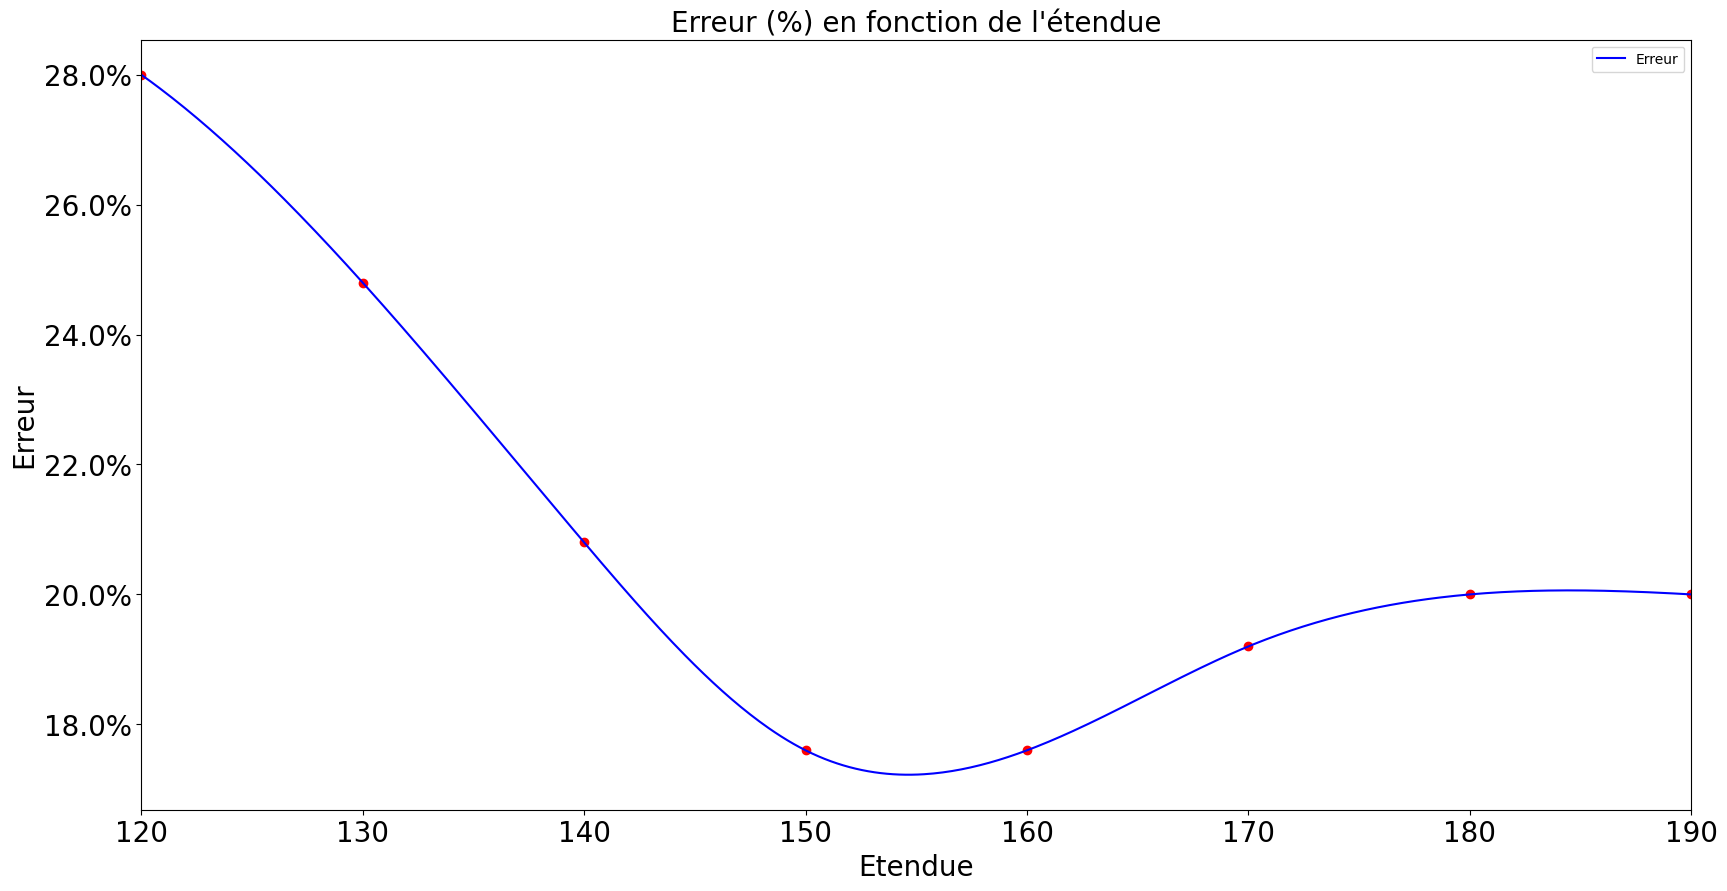

In [18]:
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import PercentFormatter

valeurs_caracteristique = []
erreur_caracteristique = []
for seuil_etendue in range(120, 200, 10):
    config = {'caracteristiques_a_utiliser': '3', 'seuil_3': seuil_etendue}
    erreur = train(config, False)['erreur']
    valeurs_caracteristique.append(seuil_etendue)
    erreur_caracteristique.append(erreur)

x_dense = np.linspace(min(valeurs_caracteristique), max(valeurs_caracteristique), 500)  # 500 points pour une courbe lisse
spline = make_interp_spline(valeurs_caracteristique, erreur_caracteristique)
y_dense = spline(x_dense)

plt.figure(figsize=(20, 10))
plt.plot(x_dense, y_dense, label='Erreur', color='b')
plt.scatter(valeurs_caracteristique, erreur_caracteristique, color='r')
plt.gca().tick_params(axis='y', which='major', labelsize=20) 
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=1))
plt.xticks(fontsize=20)
plt.xlabel("Etendue", fontsize=20)
plt.ylabel('Erreur', fontsize=20)
plt.xlim(min(valeurs_caracteristique), max(valeurs_caracteristique))
plt.title("Erreur (%) en fonction de l'étendue", fontsize=20)
plt.legend()


In [19]:
# l'étudiant devra remplacer le 100 ci dessous

seuil_etendue = 100

config = {'caracteristiques_a_utiliser': '3', 'seuil_3': seuil_etendue}
metrics = train(config, False)
print(f"Erreur obtenue: {round(100*metrics['erreur'],1)}%")


Erreur obtenue: 52.8%


<hr style="height:2px; border-width:0; color:black; background-color:black">
<span style="font-size: 48px;">2ème partie</span>
<hr style="height:2px; border-width:0; color:black; background-color:black">

# Faire constater par l'étudiant que l'écart type observé pour les sujets malades est en moyenne plus élevé que l'écart type observé pour les sujets sains

In [20]:
def display_stats_std_dev():
    std_dev_target_0 =[]
    srd_dev_target_1 =[]
    for id in id_to_fhr_last_hour.keys():
        std_dev = compute_id_std_dev_last_hour(id)
        if 0 == id_to_target[id]:
            std_dev_target_0.append(std_dev)
        else:
            srd_dev_target_1.append(std_dev)
    print(f'Ecart type:')
    print(f'\tMoyenne pour les sujets sains = {round(np.mean(std_dev_target_0),1)}')
    print(f'\tMoyenne pour les sujets malades = {round(np.mean(srd_dev_target_1),1)}')
display_stats_std_dev()

Ecart type:
	Moyenne pour les sujets sains = 15.0
	Moyenne pour les sujets malades = 25.5


# Affichage de la qualité de  l'outil en fonction du seuil d'écart type choisi pour identifier les sujets malades

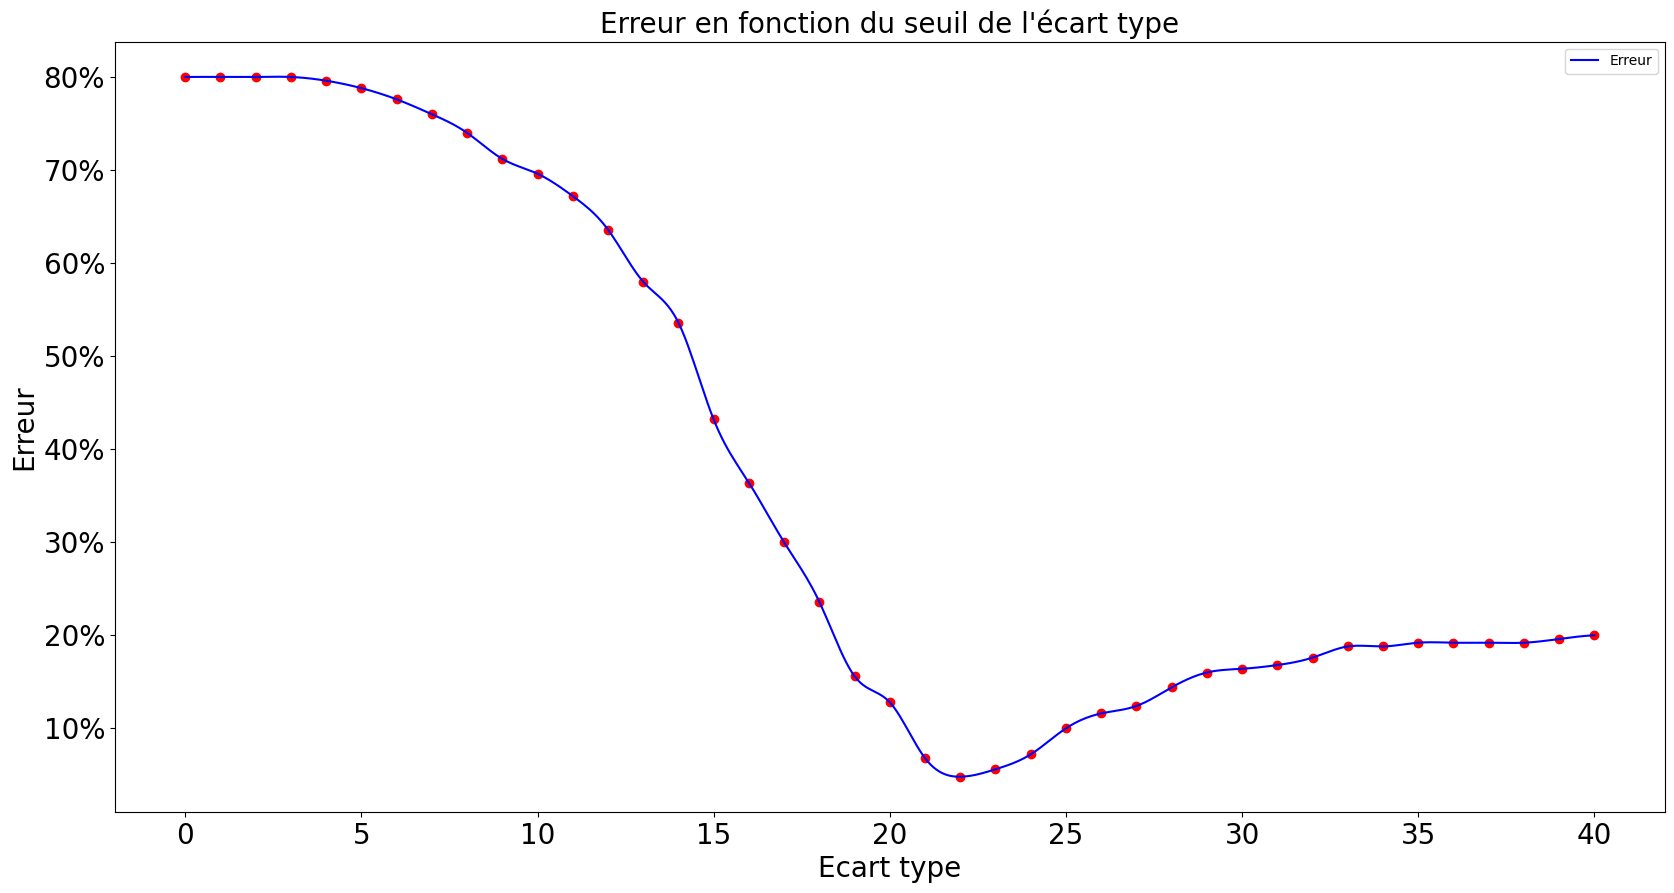

In [21]:
valeurs_caracteristique = []
erreur_caracteristique = []
for threshold_ecart_type in range(0,40+1,1):
    config = {'caracteristiques_a_utiliser': '1', 'seuil_1': threshold_ecart_type}
    erreur = train(config, False)['erreur']
    valeurs_caracteristique.append(threshold_ecart_type)
    erreur_caracteristique.append(erreur)

x_dense = np.linspace(min(valeurs_caracteristique), max(valeurs_caracteristique), 500)  # 500 points pour une courbe lisse
spline = make_interp_spline(valeurs_caracteristique, erreur_caracteristique)
y_dense = spline(x_dense)

plt.figure(figsize=(20, 10))
plt.plot(x_dense, y_dense, label='Erreur', color='b')
plt.scatter(valeurs_caracteristique, erreur_caracteristique, color='r')
plt.gca().tick_params(axis='y', which='major', labelsize=20) 
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(fontsize=20)
plt.xlabel("Ecart type", fontsize=20)
plt.ylabel('Erreur', fontsize=20)
plt.title("Erreur en fonction du seuil de l'écart type", fontsize=20)
plt.legend()


# On demande à l'étudiant de choisir le seuil pour l'écart type 

In [22]:
# l'étudiant devra remplacer le 10 ci dessous
seuil_ecart_type = 10

config = {'caracteristiques_a_utiliser': '1', 'seuil_1': seuil_ecart_type}
metrics = train(config, False)
print(f"Erreur obtenue: {round(100*metrics['erreur'],1)}%")


Erreur obtenue: 69.6%


<hr style="height:2px; border-width:0; color:black; background-color:black">
<span style="font-size: 48px;">3ème partie</span>
<hr style="height:2px; border-width:0; color:black; background-color:black">

# On combine les 2 caractéristiques précédentes

# PRIVE: Affichage de graphiques montrant les sujets sains et les sujets malades en fonction de 2 caractéristiques

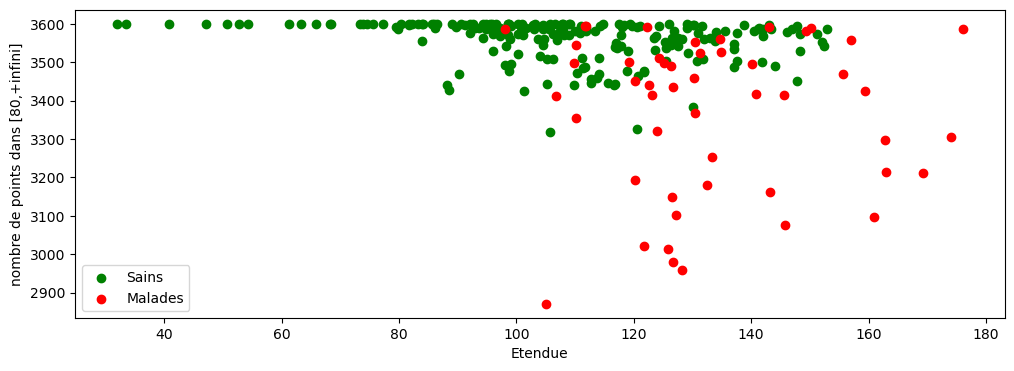

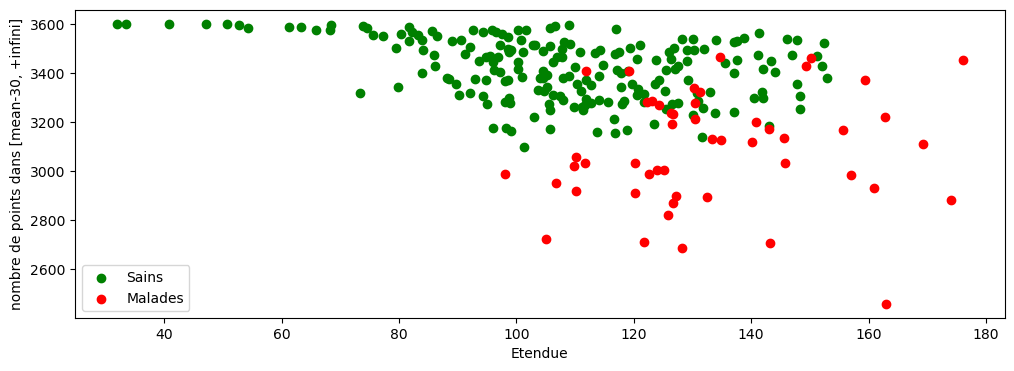

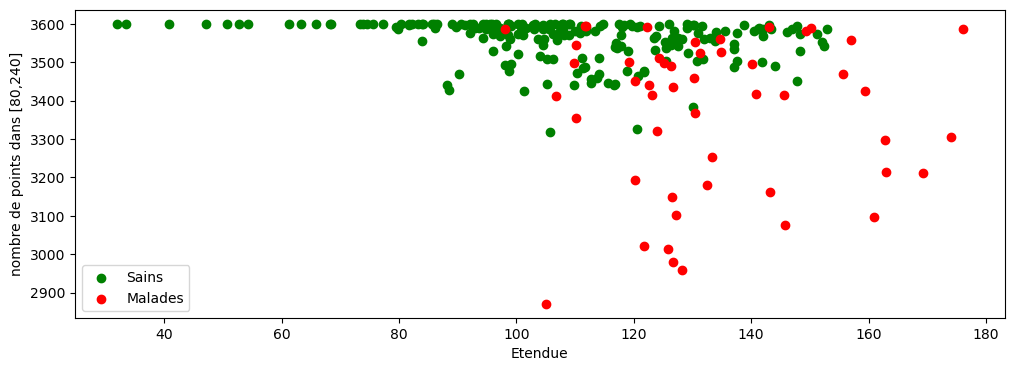

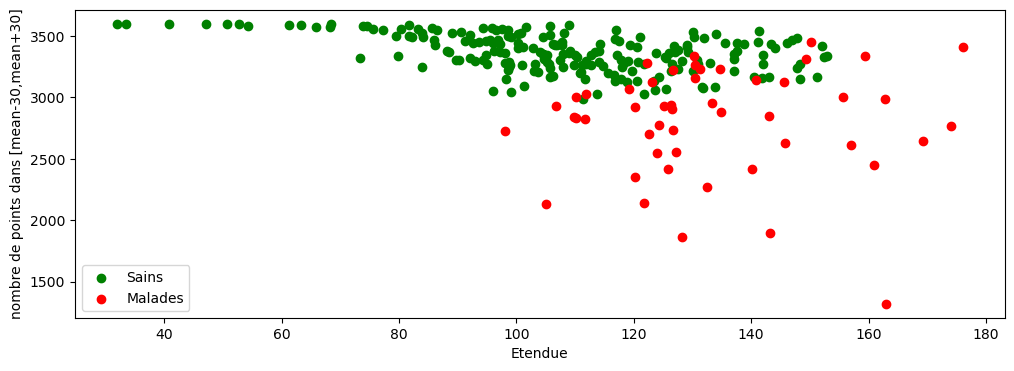

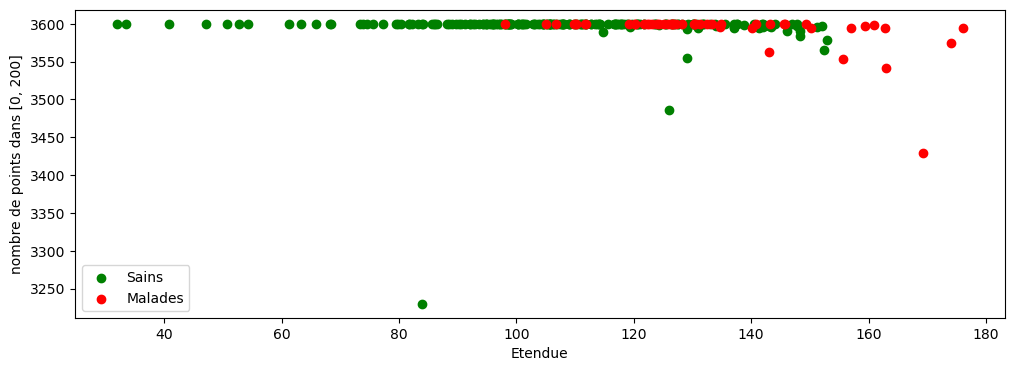

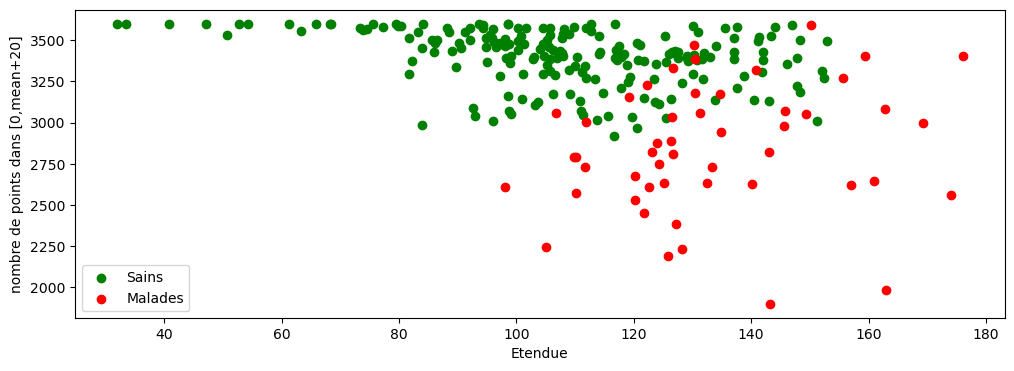

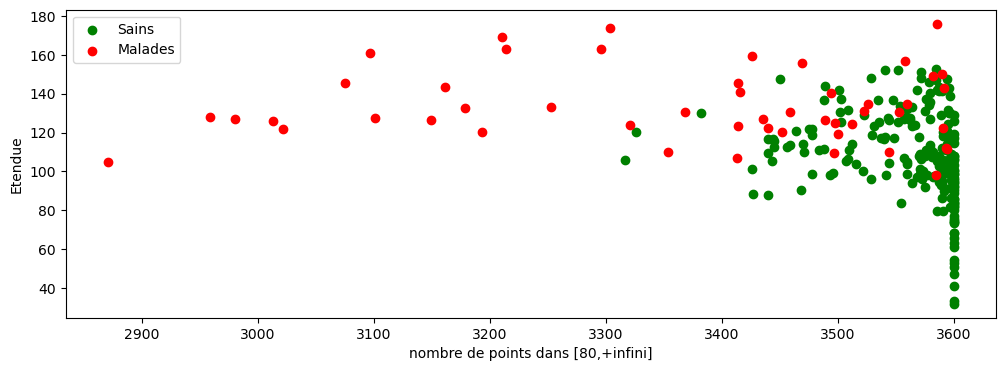

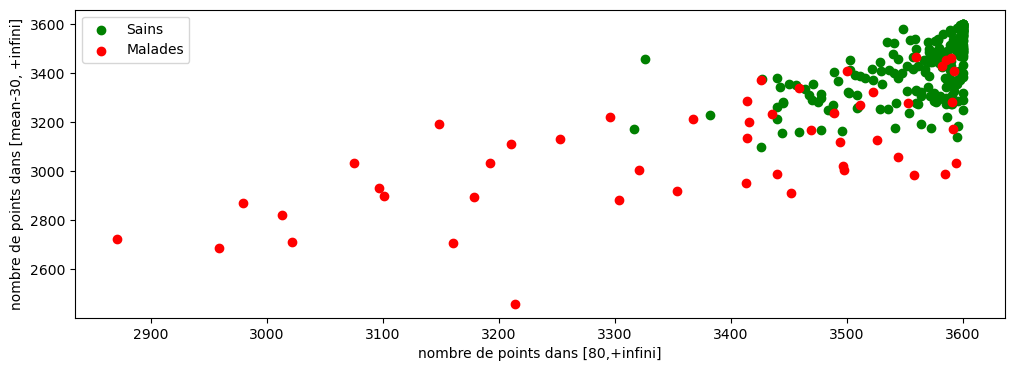

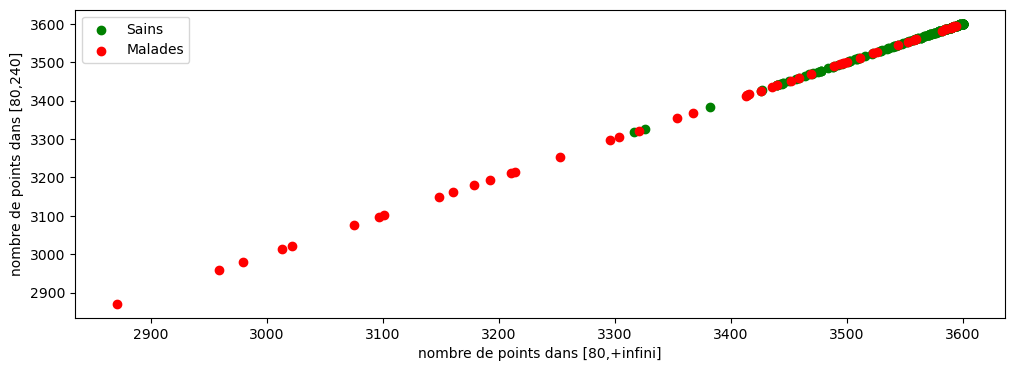

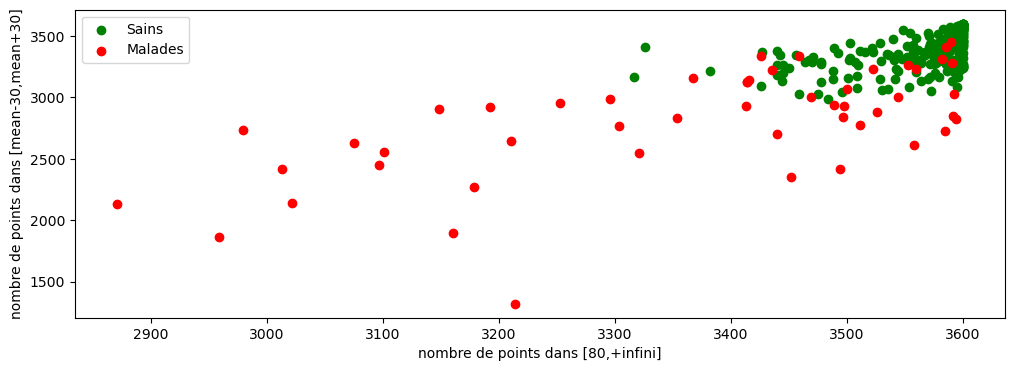

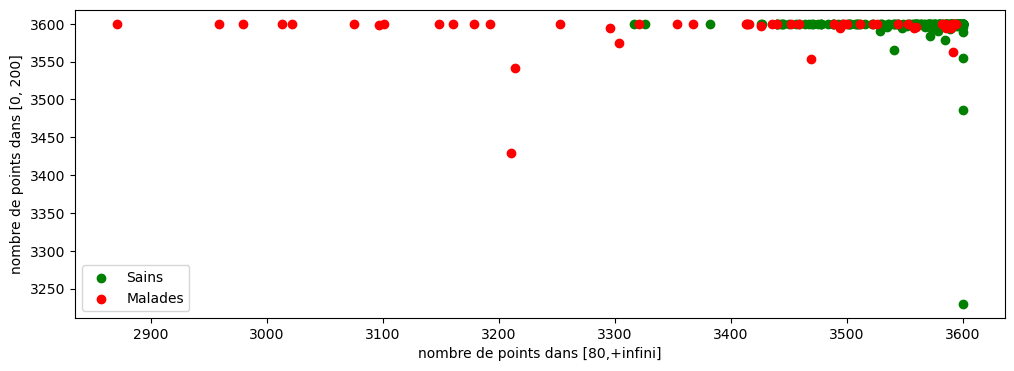

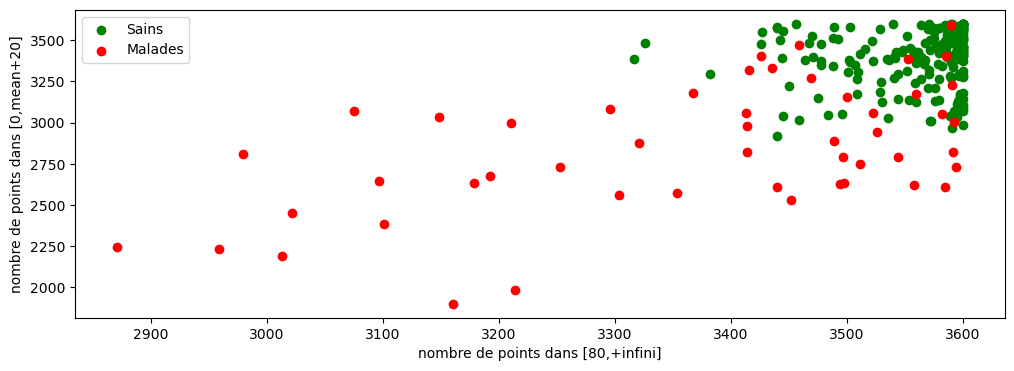

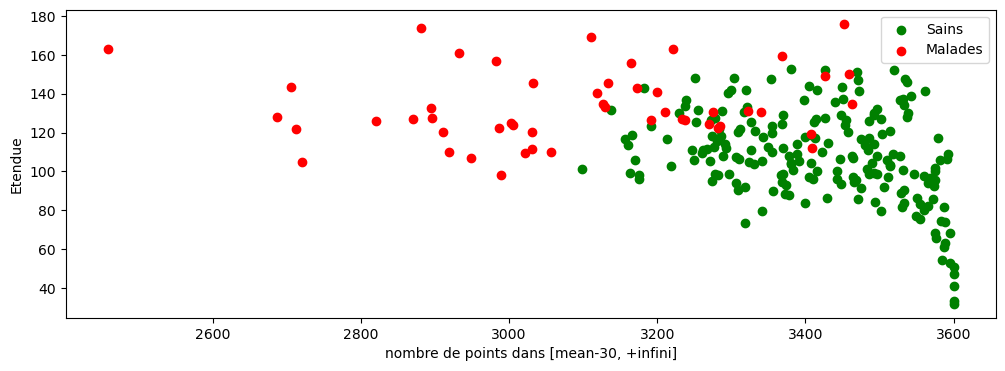

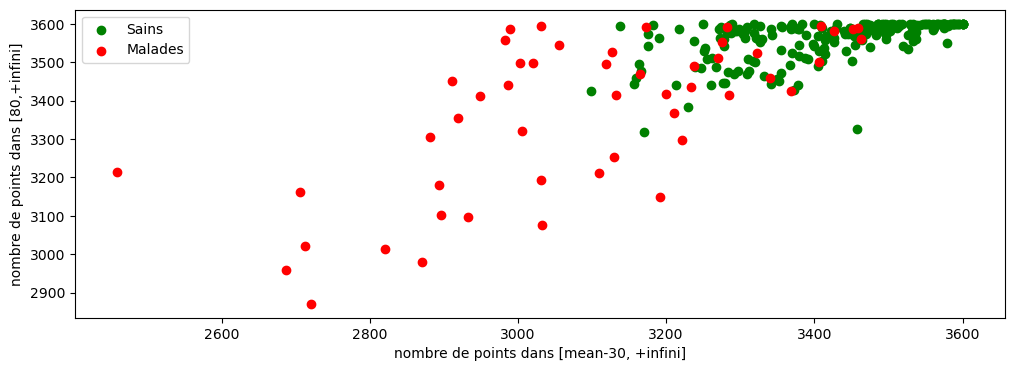

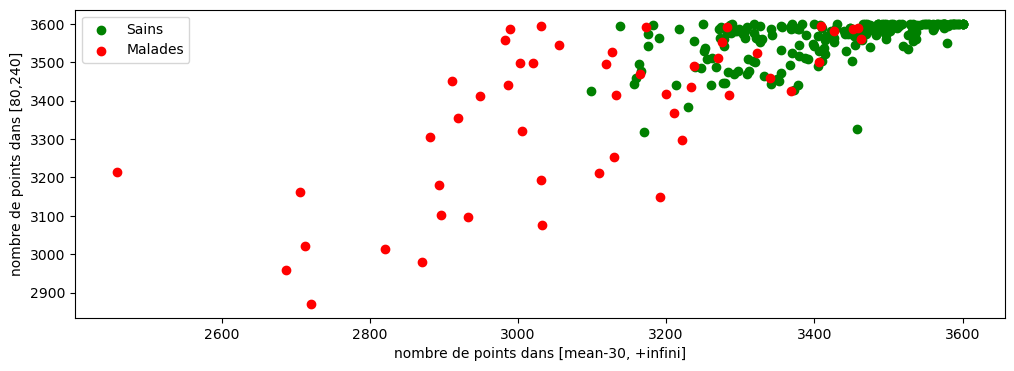

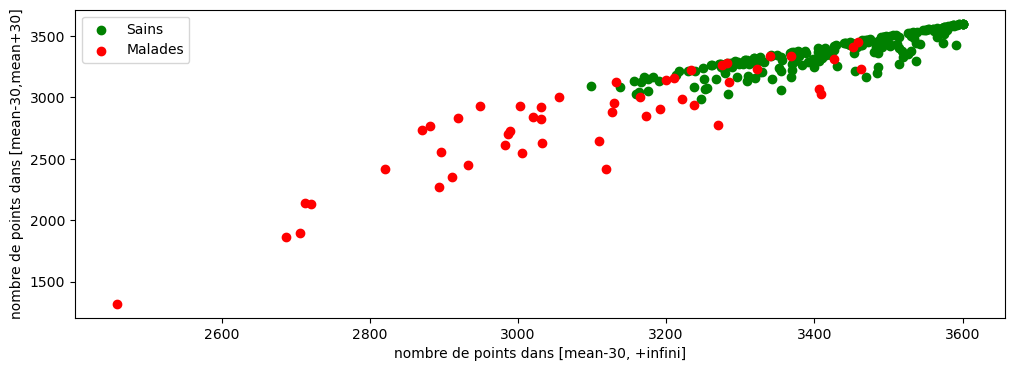

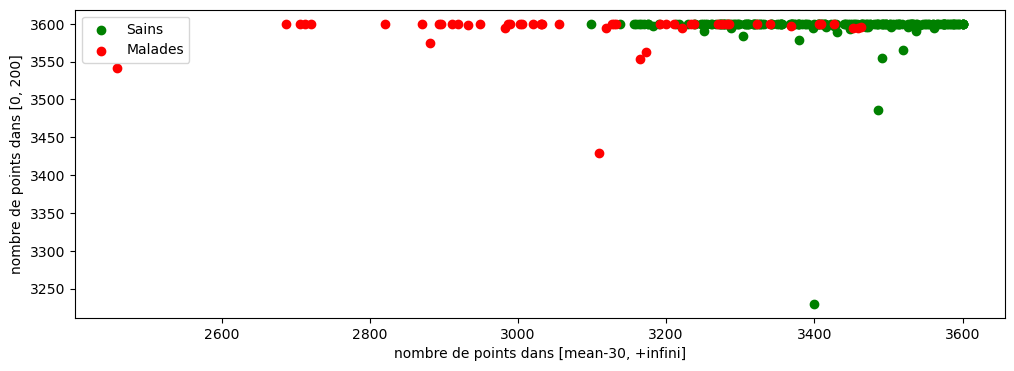

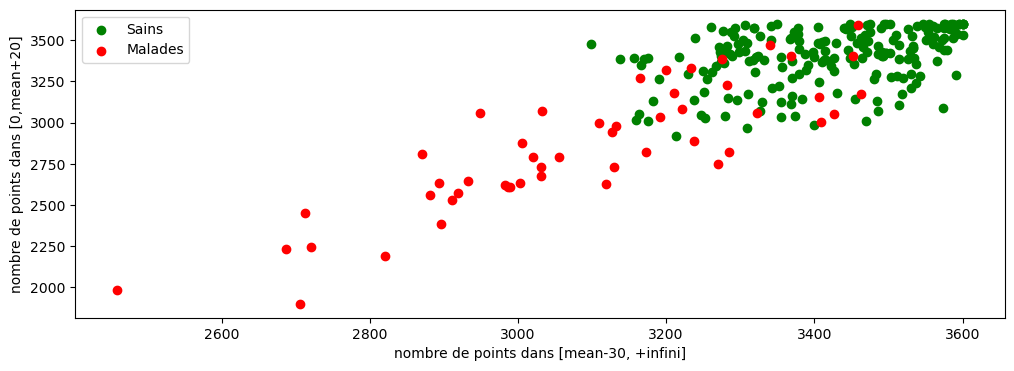

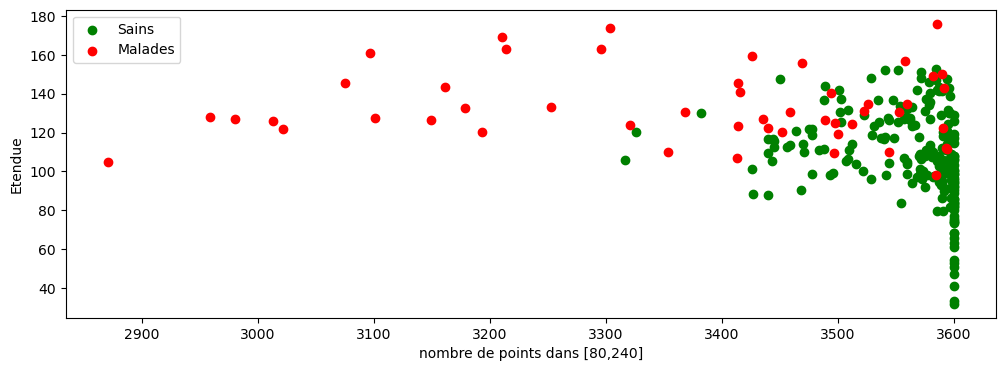

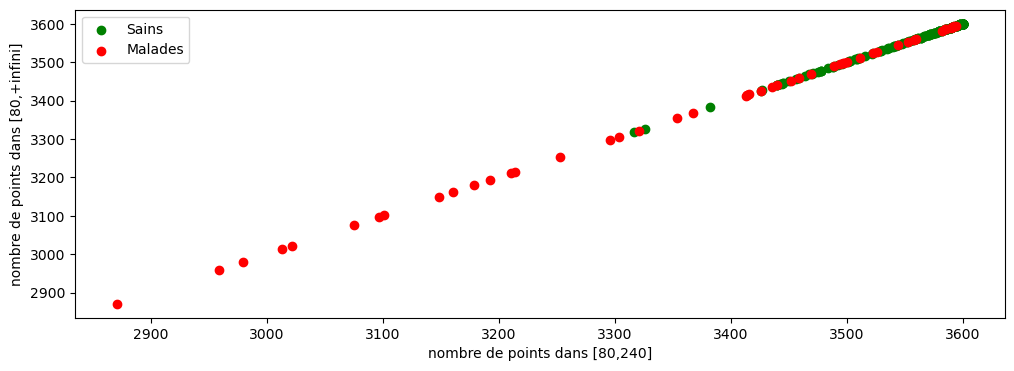

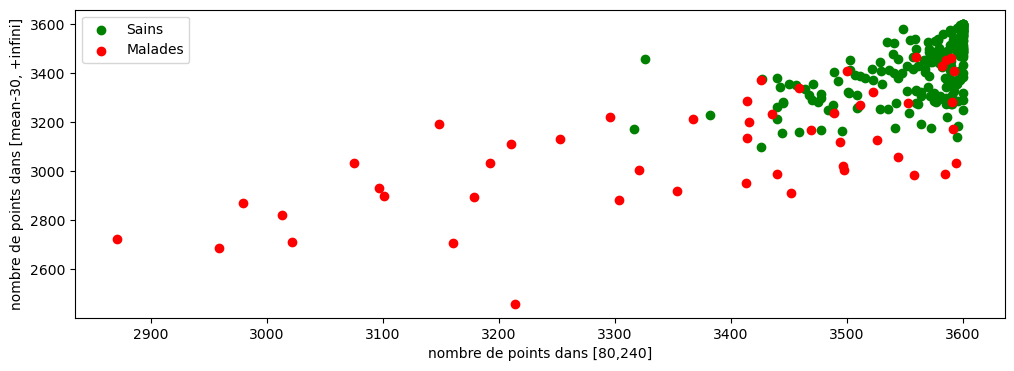

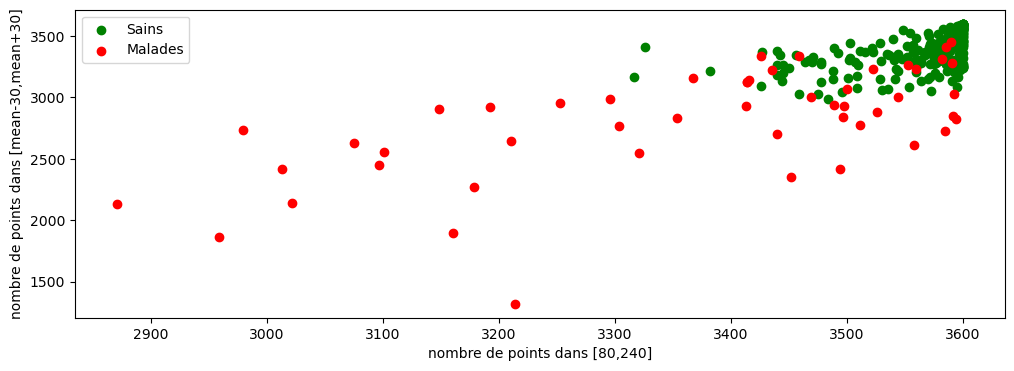

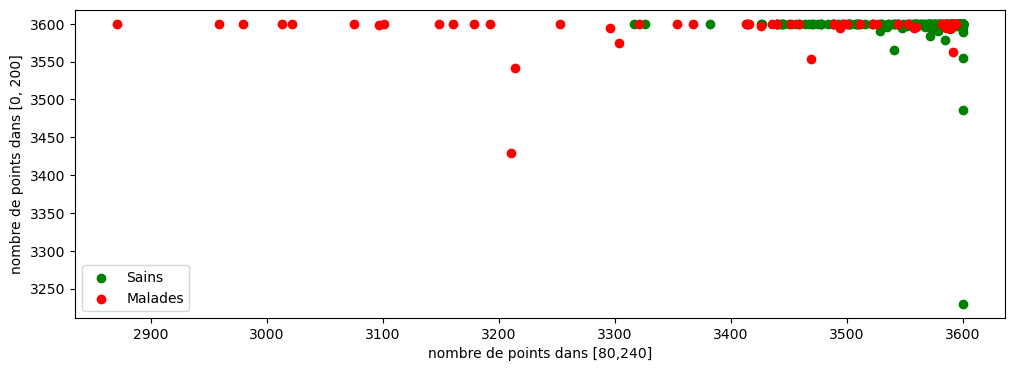

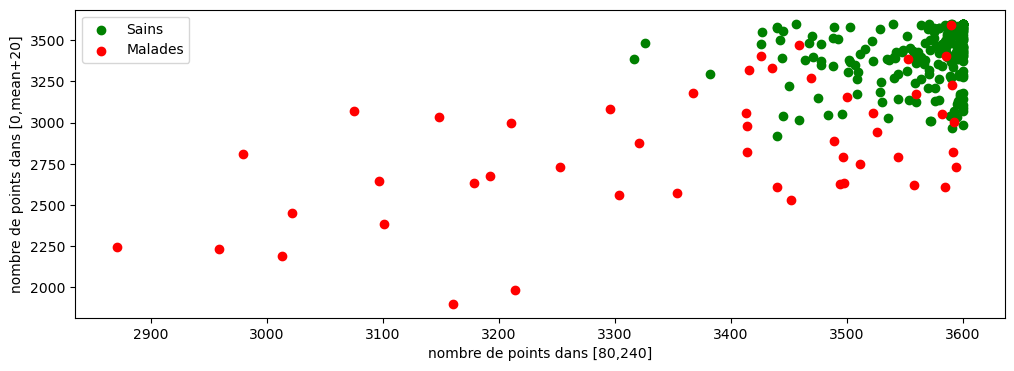

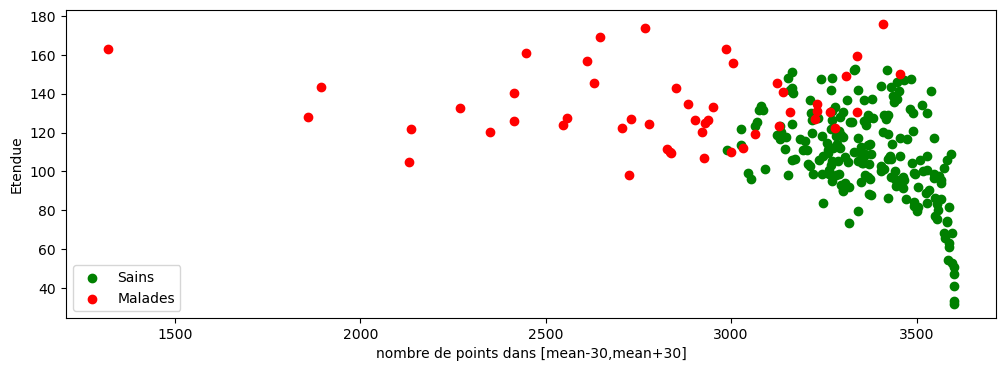

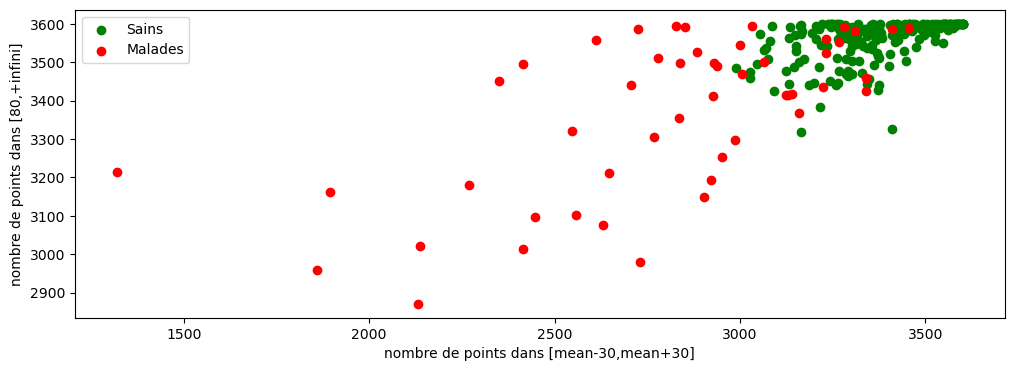

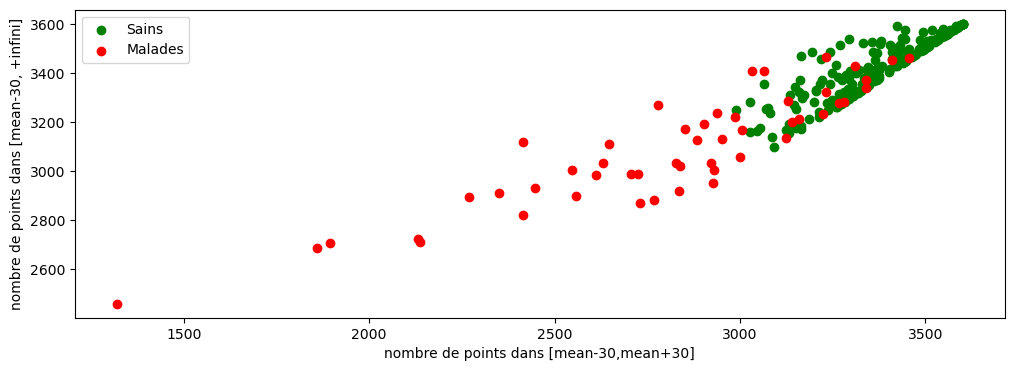

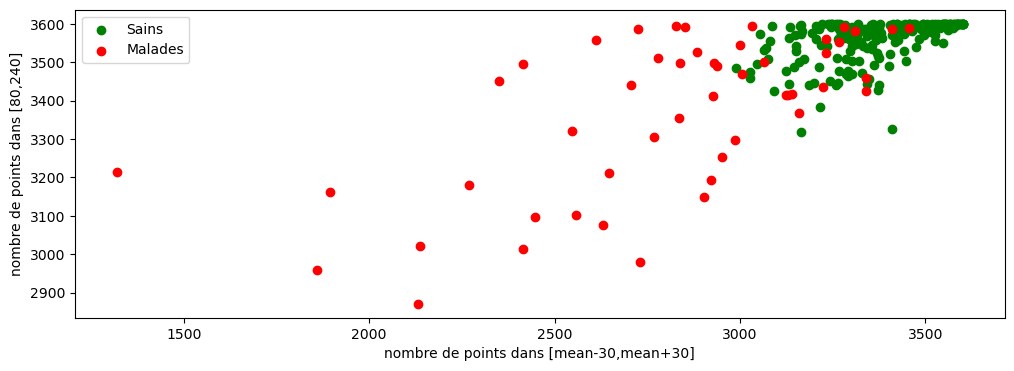

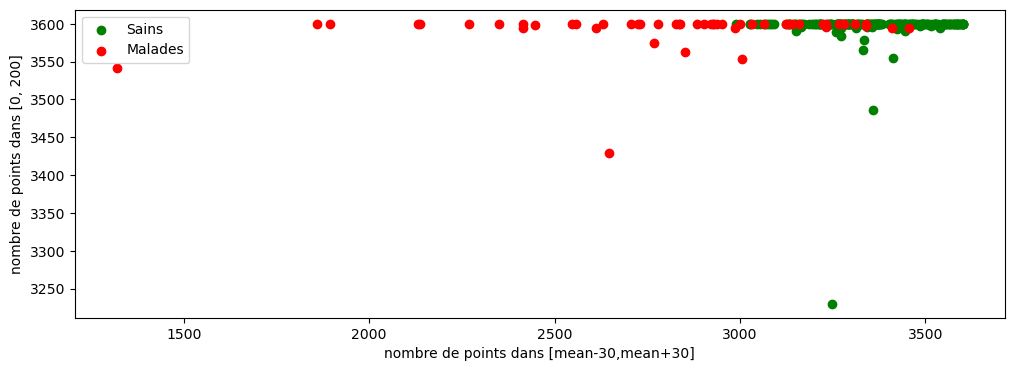

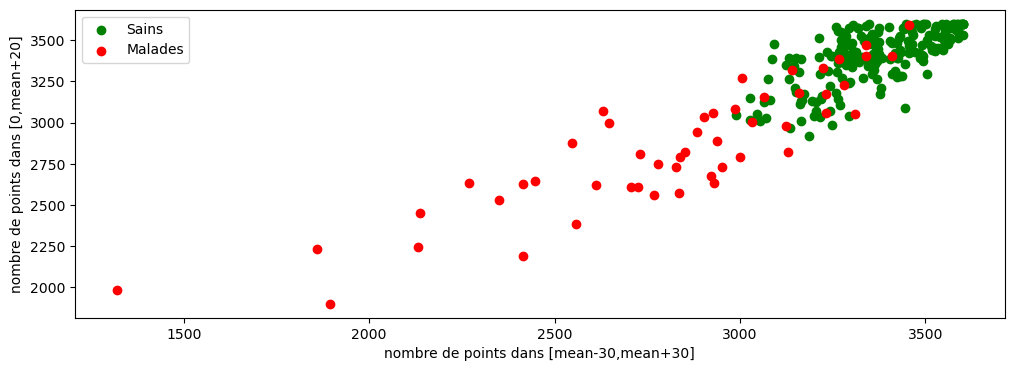

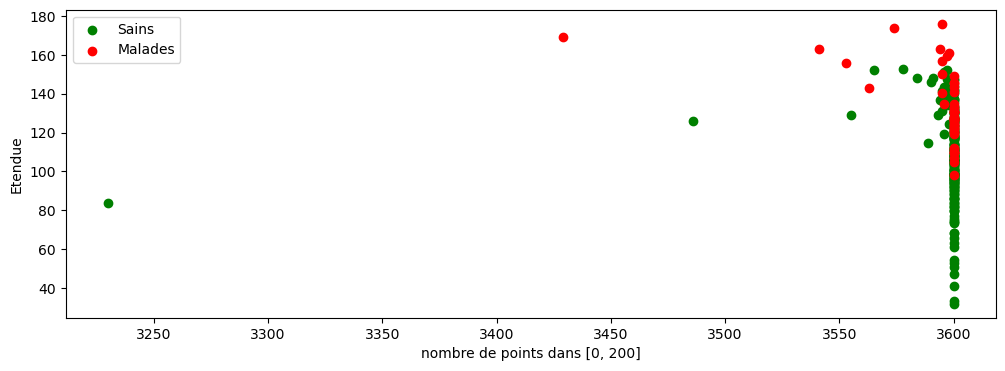

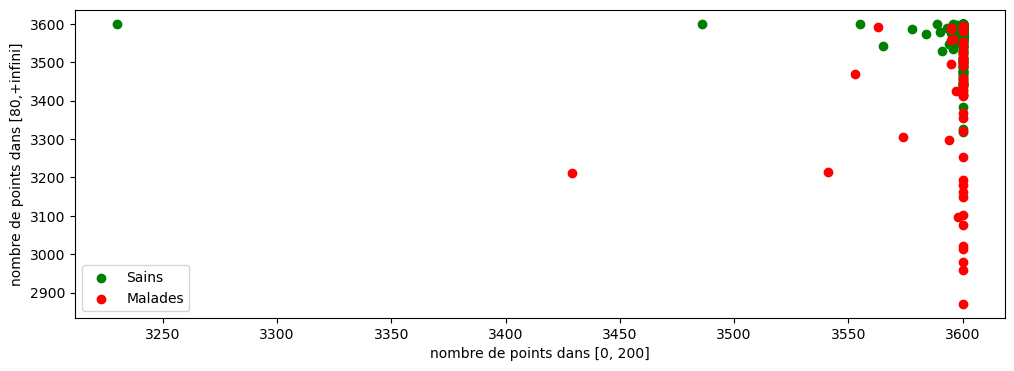

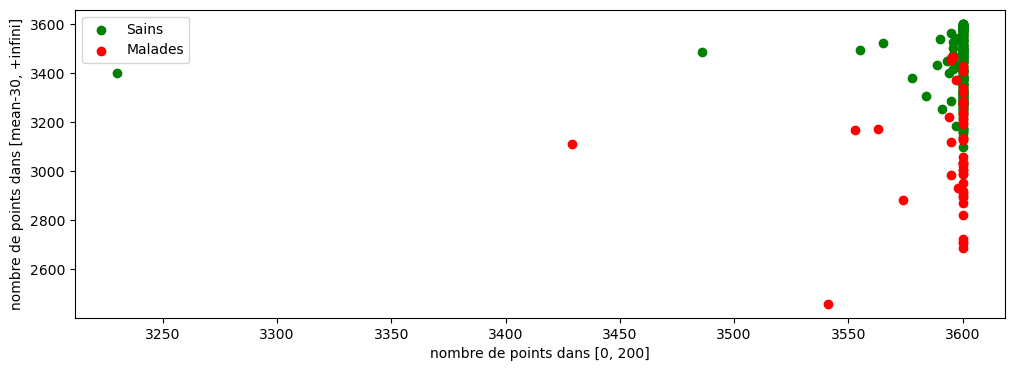

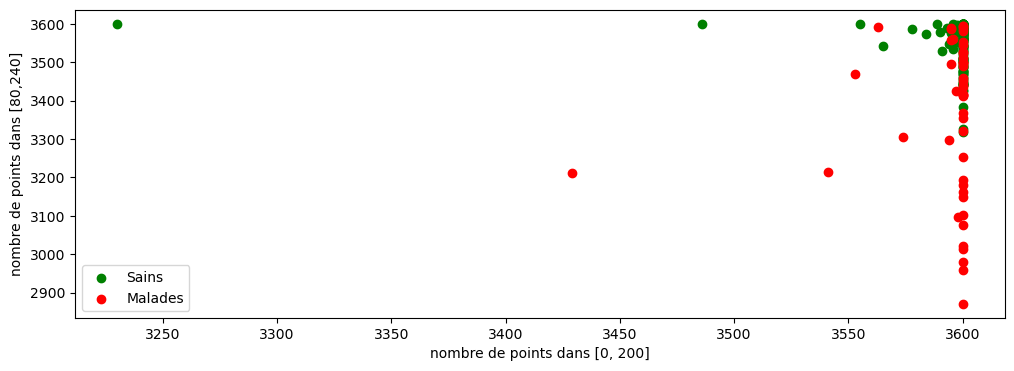

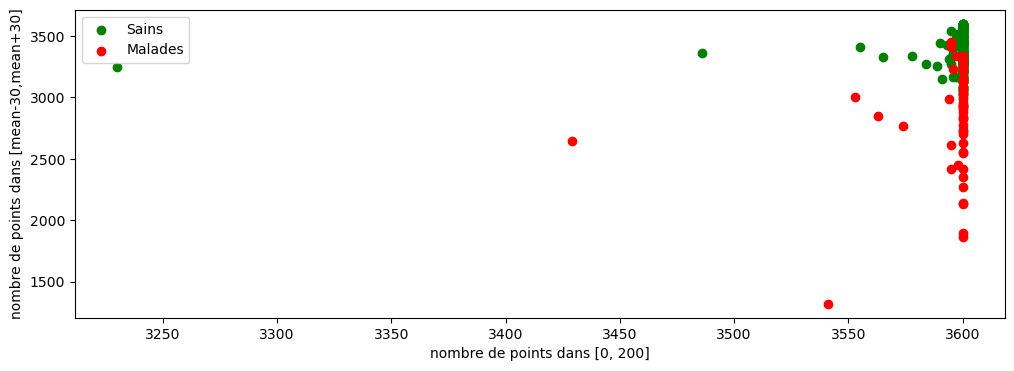

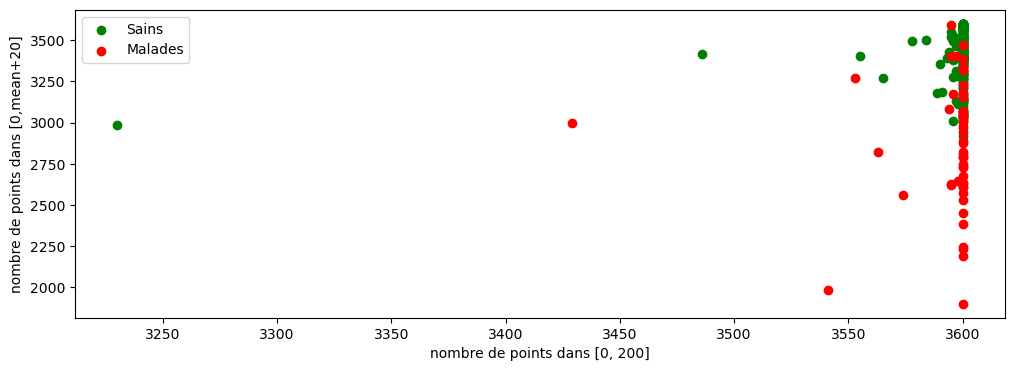

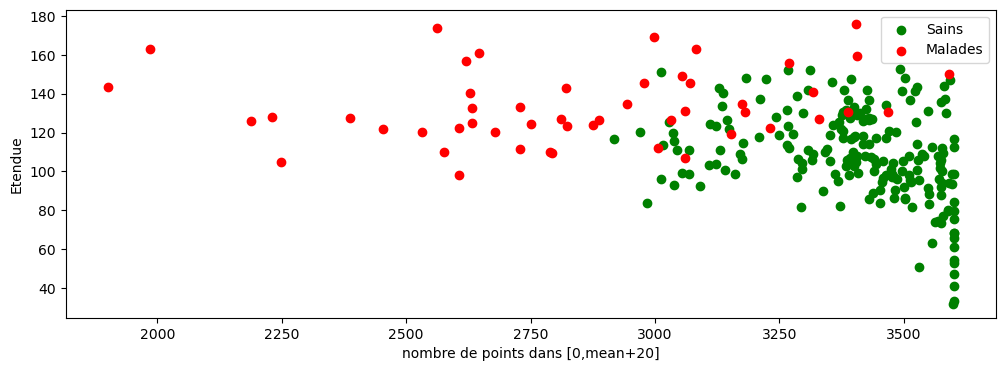

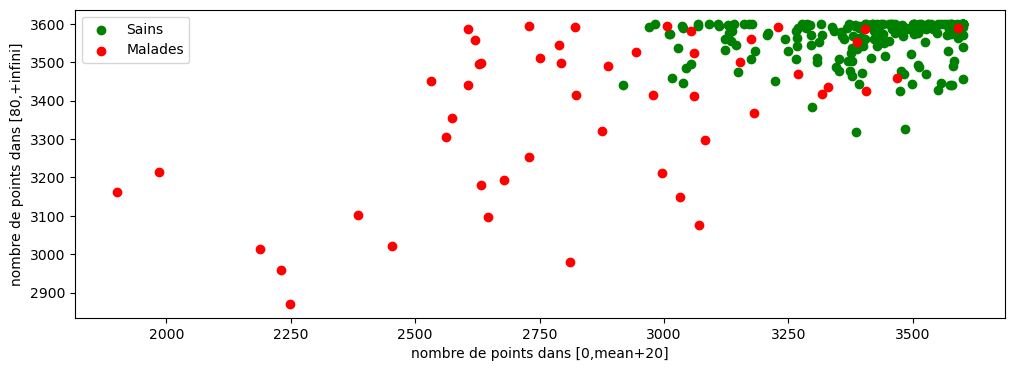

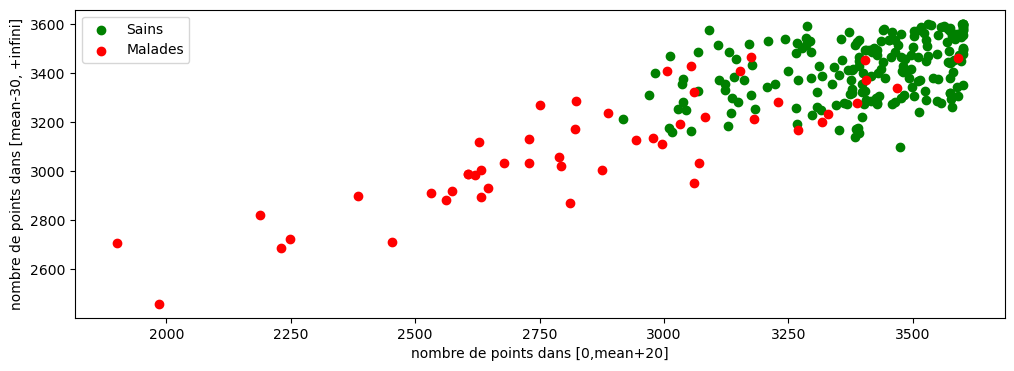

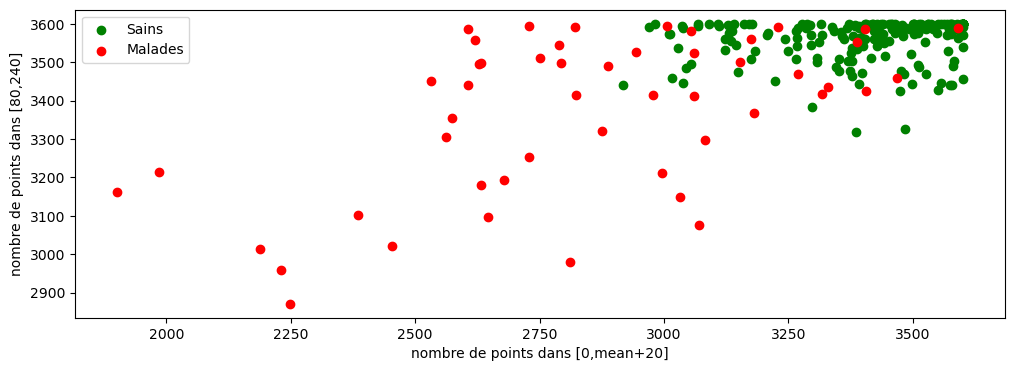

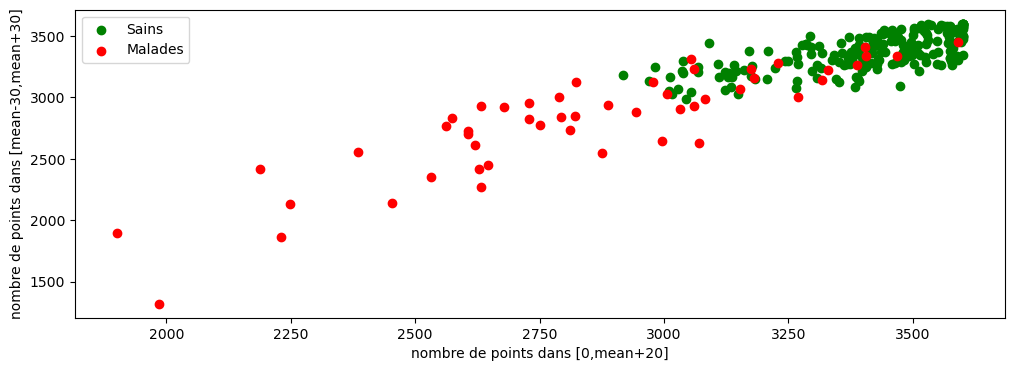

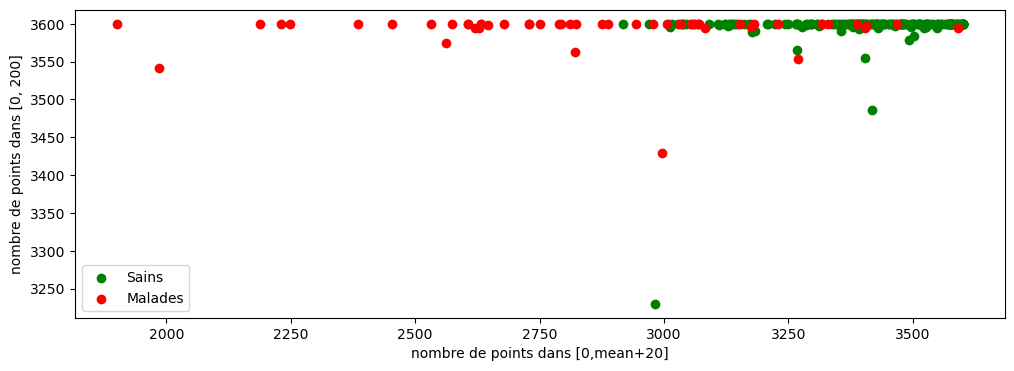

In [23]:

# caractéristique 6:  calcul le nombre de points dans l'intervalle [80, +infini]
@functools.lru_cache(maxsize=None)
def compute_count_in_range_80_infinite(id: int):
    return points_in_interval_last_hour(id, 80, 999)

# caractéristique 6C:  calcul le nombre de points dans l'intervalle [mean-30, +infini]
@functools.lru_cache(maxsize=None)
def compute_count_in_range_mean_minus30_infinite(id: int):
    mean = compute_id_mean_last_hour(id)
    return points_in_interval_last_hour(id, mean-30, 999)

# caractéristique 7:  calcul le nombre de points dans l'intervalle [80, 240]
@functools.lru_cache(maxsize=None)
def compute_count_in_range_80_240(id: int):
    return points_in_interval_last_hour(id, 80, 240)

# caractéristique 7D: calcul le nombre de points dans l'intervalle [mean-30, mean+30]
@functools.lru_cache(maxsize=None)
def compute_count_in_range_mean_minus30_mean_plus30(id: int):
    mean = compute_id_mean_last_hour(id)
    return points_in_interval_last_hour(id, mean-30, mean+30)

# caractéristique 8:  calcul le nombre de points dans l'intervalle [0, 200]
@functools.lru_cache(maxsize=None)
def compute_count_in_range_0_200(id: int):
    return points_in_interval_last_hour(id, 0, 200)

# caractéristique 8C:  calcul le nombre de points dans l'intervalle [0, mean+20]
@functools.lru_cache(maxsize=None)
def compute_count_in_range_0_mean_plus20(id: int):
    mean = compute_id_mean_last_hour(id)
    return points_in_interval_last_hour(id, 0, mean+20)




def display_plot(x_method, x_method_name:str, y_method, y_method_name:str):
    label0_coordinates = []
    label1_coordinates = []
    for id in id_to_fhr_last_hour.keys():
        x =x_method(id)
        y =y_method(id)
        if id_to_target[id] == 0:
            label0_coordinates.append((x,y))
        else:
            label1_coordinates.append((x,y))
    x_label0, y_label0 = zip(*label0_coordinates)
    plt.figure(figsize=(12, 4))
    plt.scatter(x_label0, y_label0, color='green', label='Sains')
    x_label1, y_label1 = zip(*label1_coordinates)
    plt.scatter(x_label1, y_label1, color='red', label='Malades')
    #plt.title('Sujets sains et malades')
    plt.xlabel(x_method_name)
    plt.ylabel(y_method_name)
    # Adding a legend to distinguish the series
    plt.legend()
    plt.show()
    
caracteristiques = [
                    #(compute_id_std_dev_last_hour, "Ecart type"), 
                    (compute_id_range_last_hour, "Etendue"), #3
                    (compute_count_in_range_80_infinite, "nombre de points dans [80,+infini]"), #6
                    (compute_count_in_range_mean_minus30_infinite, "nombre de points dans [mean-30, +infini]"), #6C
                    (compute_count_in_range_80_240, "nombre de points dans [80,240]"), #7
                    (compute_count_in_range_mean_minus30_mean_plus30, "nombre de points dans [mean-30,mean+30]"), #7D
                    (compute_count_in_range_0_200, "nombre de points dans [0, 200]"), #8
                    (compute_count_in_range_0_mean_plus20, "nombre de points dans [0,mean+20]"), #8C 
    
                   ]

for (x_method, x_method_name) in caracteristiques:
    for (y_method, y_method_name) in caracteristiques:
        if x_method_name == y_method_name:
            continue            
        display_plot(x_method, x_method_name, y_method, y_method_name)


# On demande à l'étudiant de choisir la valeur de ces 2 caractéristiques
## On considère qu'un sujet est malade si l'étendue est supérieure au seuil indiqué ou si l'écart type est supérieur au seuil associé

In [24]:
# l'étudiant devra remplacer les 2 valeurs ci dessous

seuil_ecart_type = 10
seuil_etendue = 100


config = {'caracteristiques_a_utiliser': '1+3', 'seuil_1': seuil_ecart_type, 'seuil_3': seuil_etendue,'label_si_resultats_differents': 1}
metrics = train(config, False)
print(f"Erreur obtenue: {round(100*metrics['erreur'],1)}%")


Erreur obtenue: 71.2%
